# Metadata

DS 5001 Final Project
Rachel Grace Treene, Eve Schoenrock & Connor Nickol

# Import & Set Up

In [1]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [252]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import plotly_express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import torch
import pprint

import warnings
warnings.filterwarnings('ignore')

In [3]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']

In [4]:
def importFiles(file_name):
    LINES = pd.DataFrame(open(file_name, 'r', encoding='utf-8-sig').readlines(), columns=['line_str'])
    LINES.index.name = 'line_num'
    LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()
    return LINES

In [5]:
LINES_1 = importFiles("Book1.txt")
LINES_2 = importFiles("Book2.txt")
LINES_3 = importFiles("Book3.txt")
LINES_4 = importFiles("Book4.txt")
LINES_5 = importFiles("Book5.txt")
LINES_6 = importFiles("Book6.txt")
LINES_7 = importFiles("Book7.txt")

In [6]:
title_1 = 'The Philosopher\'s Stone'
title_2 = 'The Chamber of Secrets'
title_3 = 'The Prisoner of Azkaban'
title_4 = 'The Goblet of Fire'
title_5 = 'The Order of the Phoenix'
title_6 = 'The Half Blood Prince'
title_7 = 'The Deathly Hallows'

## Clip Cruft

In [7]:
LINES_1 = LINES_1.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_2 = LINES_2.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[15:]
LINES_3 = LINES_3.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Harry Potter and the Goblet of Fire)\s+(.*)', value = '', regex = True).loc[5:]
LINES_5 = LINES_5.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[11:]
LINES_6 = LINES_6.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[10:]
LINES_7 = LINES_7.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[6:]

# Chunk by Chapter

## Function to chunk by chapter: `chunk_chaps`

Note that this function is specific to each book since chapter regex changes across books. Be sure to update regex accordingly here.

In [13]:
# function to find chapter chunks
def chunk_chaps(lines, chap_pat, book_num):
    '''
    This function will achieve chapter chunking automatically for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        lines (dataframe) - dataframe of lines
        chap_pat (str) - chapter specific regex (chap_pat)
        book_num (int) - the Harry Potter series number (1-7); determines which chap_pat to continue with
    
    OUTPUT:
        chaps
    '''
    chap_lines = lines.line_str.str.match(chap_pat, case=True)
    
    # book specific regex
    if book_num == 1:
        # chap_pat = r"^\s*([A-Z\'\s]+|[A-Z\s]+)\s*$"
        a = lines.loc[chap_lines]
        a = a.drop([2394, 3124, 3127, 3147, 3182, 3196, 3197, 4990, 4992, 11155]) # 11155 because it's the second line of a chapter title - we don't want it to count as a standalone chapter title
        chap_titles = a.index.values.tolist()
    
    elif book_num == 2:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!,.-]')] # removes lines with digits, ?, !, ., and -
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I'))] # removes lines ending with ", ., !, and I
        a = a.drop([1019, 2851, 2855, 4266, 6147, 10864])
        chap_titles = a.index.values.tolist()
        
    elif book_num == 3:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.-;]')] # removes lines with digits, ?, !, ., and -
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I', 'EMPLOYEE', 'PRIZE', 'OWN', 'YOU', 'LILY'))] # removes lines ending with these things
        a = a.drop([1723, 2373, 9413, 9718, 15425, 17183, 17598]) # last 3 are secondary title lines - remove these later for book 3
        chap_titles = a.index.values.tolist()
        
    elif book_num == 4:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I', 'WORLD', 'STINKS', 'MISTAKE', 'POTTER', 'RIDDLE'))] # removes lines ending with these things
        a = a.drop([11945, 10281]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 5:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([  916,  1216,  1500,  1581,  1844,  1952,  3362,  3731,  3732,
        3766,  3777,  3785,  4794,  4795,  5594,  6120,  6121,  6122,
        6350, 10216, 10219, 10858, 10861, 11341, 12553, 16328, 17412,
       17414, 19936, 19998, 20032, 23056, 23058, 23273, 23289, 23305,
       23353, 23399, 23401, 23403, 23444, 26538, 27597, 27603, 27614,
       27657, 30989, 30993, 31090, 31092, 31336, 31349, 32914, 32916,
       32917, 32919, 33058, 33070, 35478, 35491, 36451, 36458, 37319,
       37357, 37398, 43684, 43685, 46208, 46857, 48038]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 6:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([1924, 1997, 1999, 2001, 5046, 5447, 5714, 5718, 5719, 5721, 17672, 27286]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 7:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([766, 10376, 10378, 10877, 10878, 11262, 11263, 12346, 12487, 12532, 12534, 12538, 12540, 12611, 16481, 16484, 17597, 19978, 19984, 20328]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
        
    # assign numbers to chapters
    lines.loc[chap_titles, 'chap_num'] = [i+1 for i in range(lines.loc[chap_titles].shape[0])]
    # forward fill chapter numbers
    lines.chap_num = lines.chap_num.ffill()
    # clean up
    lines = lines.drop(chap_titles)
    if book_num in {1, 3, 5, 7}: 
        if book_num == 1:
            addl_titles = [4215, 11155]
        if book_num == 3:
            addl_titles = [15425, 17183, 17598] # second title lines for 3 chapters in book 3
        if book_num == 5:
            addl_titles = [3363, 5595, 19937, 26539]
        if book_num == 7:
            addl_titles = [12346, 17597, 20328]
        lines = lines.drop(addl_titles) # drop additional title lines that were not caught before
    
    # Make big string for each chapter
    chaps = lines.groupby(OHCO[:1])\
        .line_str.apply(lambda x: '\n'.join(x))\
        .to_frame('chap_str')
    chaps['chap_str'] = chaps.chap_str.str.strip() # clip cruft from chap strings
    
    return a, chaps

## Book 1: Chunked by Chapter

In [14]:
chunk_chaps1 = chunk_chaps(LINES_1, r"^\s*([A-Z\'\s]+|[A-Z\s]+)\s*$", 1)

In [15]:
chaps1_titles = chunk_chaps1[0]
chaps1 = chunk_chaps1[1]

In [16]:
chaps1_titles

line_str  chap_num
line_num                                     
5                 THE BOY WHO LIVED       1.0
786              THE VANASHIG GLASS       2.0
1399        THE LETTERS FROM NO ONE       3.0
2124         THE KEEPER OF THE KEYS       4.0
2856                    DIAGON ALLY       5.0
4214      THE JOURNEY FROM PLATFORM       6.0
5515                THE SORTING HAT       7.0
6400             THE POTIONS MASTER       8.0
6952              THE MIDNIGHT DUEL       9.0
7964                      HALLOWEEN      10.0
8795                      QUIDDITCH      11.0
9456           THE MIRROR OF ERISED      12.0
10504               NICHOLAS FLAMBL      13.0
11154         NORBERT THE NORWEGIAN      14.0
11847          THE FORBIDDEN FOREST      15.0
12817          THROUGH THE TRAPDOOR      16.0
14168        THE MAN WITH TWO FACES      17.0

In [17]:
chaps1

chap_str
chap_num                                                   
1.0       Mr. and Mrs. Dursley, of number four, Privet D...
2.0       Nearly ten years had passed since the Dursleys...
3.0       The escape of the Brazilian boa constrictor ea...
4.0       BOOM. They knocked again. Dudley jerked awake....
5.0       Harry woke early the next morning. Although he...
6.0       Harry’s last month with the Dursleys wasn’t fu...
7.0       The door swung open at once. A tall, black-hai...
8.0       “There, look.”\n\n“Where?”\n\n“Next to the tal...
9.0       Harry had never believed he would meet a boy h...
10.0      Malfoy couldn’t believe his eyes when he saw t...
11.0      As they entered November, the weather turned v...
12.0      Christmas was coming. One morning in mid-\nDec...
13.0      Dumbledore had convinced Harry not to go looki...
14.0      Quirrell, however, must have been braver than ...
15.0      Things couldn’t have been worse.\n\nFilch took...
16.0      In years to come, Harry would never quite reme...
17.0      It was Quirrell.\n\n“You\” gasped Harry.\n\nQu...

## Book 2: Chunked by Chapter

In [18]:
chunk_chaps2 = chunk_chaps(LINES_2, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 2)

In [19]:
chaps2_title = chunk_chaps2[0]
chaps2 = chunk_chaps2[1]

In [20]:
chaps2_title

line_str
line_num                         
15             THE WORST BIRTHDAY
523               DOBBY’S WARNING
1134                   THE BURROW
2017       AT FLOURISH AND BLOTTS
3116          THE WHOMPING WILLOW
4155            GILDEROY LOCKHART
5036        MUDBLOODS AND MURMURS
5919           THE DEATHDAY PARTY
6815      THE WRITING ON THE WALL
7887            THE ROGUE BLUDGER
8888             THE DUELING CLUB
10045       THE POLY JUICE POTION
11111       THE VERY SECRET DIARY
12176             CORNELIUS FUDGE
12958                      ARAGOG
13839      THE CHAMBER OF SECRETS
14987       THE HEIR OF SLYTHERIN
16010              DOBBY’S REWARD

In [21]:
chaps2

chap_str
chap_num                                                   
1.0       Not for the first time, an argument had broken...
2.0       Harry managed not to shout out, but it was a c...
3.0       “Ron\” breathed Harry, creeping to the window ...
4.0       Life at the Burrow was as different as possibl...
5.0       The end of the summer vacation came too quickl...
6.0       The next day, however, Harry barely grinned on...
7.0       Harry spent a lot of time over the next few da...
8.0       October arrived, spreading a damp chill over t...
9.0       “What’s going on here? What’s going on?”\n\nAt...
10.0      Since the disastrous episode of the pixies, Pr...
11.0      Harry woke up on Sunday morning to find the\nd...
12.0      They stepped off the stone staircase at the to...
13.0      Hermione remained in the hospital wing for sev...
14.0      Harry, Ron, and Hermione had always known that...
15.0      Summer was creeping over the grounds around th...
16.0      All those times we were in that bathroom, and ...
17.0      He was standing at the end of a very long, dim...
18.0      For a moment there was silence as Harry, Ron,\...

## Book 3: Chunked by Chapter

In [22]:
chunk_chaps3 = chunk_chaps(LINES_3, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 3)

In [23]:
chaps3_title = chunk_chaps3[0]
chaps3 = chunk_chaps3[1]

In [24]:
chaps3_title # some chapter titles span 2 lines - we dropped the second line & when dropping chapter titles from lines we also remove the second line of title

line_str
line_num                               
5                              OWL POST
677            AUNT MARGE’S BIG MISTAKE
1416                     THE KNIGHT BUS
2280                 THE LEAKY CAULDRON
3262                       THE DEMENTOR
4599              TALONS AND TEA LEAVES
5928        THE BOGGART IN THE WARDROBE
6822             FLIGHT OF THE FAT LADY
7871                        GRIM DEFEAT
8932                 THE MARAUDER’S MAP
10284                      THE FIREBOLT
11401                      THE PATRONUS
12370       GRYFFINDOR VERSUS RAVENCLAW
13206                    SNAPE’S GRUDGE
14326               THE QUIDDITCH FINAL
15424             PROFESSOR TRELAWNEY’S
16309                 CAT, RAT, AND DOG
17181     MOONY, WORMTAIL, PADFOOT, AND
17597               THE SERVANT OF LORD
18582               THE DEMENTOR’S KISS
18978                 HERMIONE’S SECRET
20550                    OWL POST AGAIN

In [25]:
chaps3 # chapter 3 strings outputted

chap_str
chap_num                                                   
1.0       Harry Potter was a highly unusual boy in many ...
2.0       Harry went down to breakfast the next morning ...
3.0       Harry was several streets away before he colla...
4.0       It took Harry several days to get used to his ...
5.0       Tom woke Harry the next morning with his usual...
6.0       When Harry, Ron, and Hermione entered the Grea...
7.0       Malfoy didn’t reappear in classes until late o...
8.0       In no time at all, Defense Against the Dark Ar...
9.0       Professor Dumbledore sent all the Gryffindors ...
10.0      Madam Pomfrey insisted on keeping Harry in the...
11.0      Harry didn’t have a very clear idea of how he ...
12.0      Harry knew that Hermione had meant well, but t...
13.0      It looked like the end of Ron and Hermione’s\n...
14.0      No one in Gryffindor Tower slept that night. T...
15.0      “He — he sent me this,” Hermione said, holding...
16.0      Harry’s euphoria at finally winning the Quiddi...
17.0      Harry’s mind had gone blank with shock. The th...
18.0      It took a few seconds for the absurdity of thi...
19.0      Hermione screamed. Black leapt to his feet. Ha...
20.0      Harry had never been part of a stranger group....
21.0      “Shocking business ... shocking ... miracle no...
22.0      “Harry!”\n\nHermione was tugging at his sleeve...

## Book 4: Chunked by Chapter

In [26]:
chunk_chaps4 = chunk_chaps(LINES_4, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 4)

In [27]:
chaps4_title = chunk_chaps4[0]
chaps4 = chunk_chaps4[1]

In [28]:
chaps4_title

line_str
line_num                                
5                       THE RIDDLE HOUSE
766                             THE SCAR
1243                      THE INVITATION
1857                  BACK TO THE BURROW
2497            WEASLEYS’ WIZARD WHEEZES
3223                         THE PORTKEY
3715                   BAGMAN AND CROUCH
4753             THE QUIDDITCH WORLD CUP
5854                       THE DARK MARK
7296              MAYHEM AT THE MINISTRY
7964         ABOARD THE HOGWARTS EXPRESS
8664            THE TRIWIZARD TOURNAMENT
9756                       MAD-EYE MOODY
10616            THE UNFORGIVABLE CURSES
11613         BEAUXBATONS AND DRUMSTRANG
12624                 THE GOBLET OF FIRE
13840                 THE FOUR CHAMPIONS
14668          THE WEIGHING OF THE WANDS
15975             THE HUNGARIAN HORNTAIL
17142                     THE FIRST TASK
18467     THE HOUSE-ELF LIBERATION FRONT
19577                THE UNEXPECTED TASK
20504                      THE YULE BALL
22099               RITA SKEBTER’S SCOOP
23361                THE EGG AND THE EYE
24464                    THE SECOND TASK
25960                    PADFOOT RETURNS
27303          THE MADNESS OF MR. CROUCH
28842                          THE DREAM
29739                       THE PENSIEVE
30996                     THE THIRD TASK
32503             FLESH, BLOOD, AND BONE
32896                   THE DEATH EATERS
33633                  PRIORI INCANTATEM
34173                        VERITASERUM
35295            THE PARTING OF THE WAYS
36503                      THE BEGINNING

In [29]:
chaps4

chap_str
chap_num                                                   
1.0       The villagers of Little Hangleton still called...
2.0       Harry lay flat on his back, breathing hard as ...
3.0       By the time Harry arrived in the kitchen, the ...
4.0       By twelve o’clock the next day, Harry’s school...
5.0       Harry spun faster and faster, elbows tucked ti...
6.0       Harry felt as though he had barely lain down t...
7.0       Harry disentangled himself from Ron and got to...
8.0       Clutching their purchases, Mr. Weasley in the ...
9.0       “ Don’t tell your mother you’ve been gambling,...
10.0      Mr. Weasley woke them after only a few hours s...
11.0      There was a definite end-of-the-holidays gloom...
12.0      Through the gates, flanked with statues of win...
13.0      The storm had blown itself out by the followin...
14.0      The next two days passed without great inciden...
15.0      Early next morning, Harry woke with a plan ful...
16.0      “I don’t believe it!” Ron said, in a stunned v...
17.0      Harry sat there, aware that every head in the ...
18.0      When Harry woke up on Sunday morning, it took ...
19.0      The prospect of talking face-to-face with Siri...
20.0      Harry got up on Sunday morning and dressed so\...
21.0      Harry, Ron, and Hermione went up to the Owlery...
22.0      “Potter! Weasley! Will you pay attention?”\n\n...
23.0      Despite the very heavy load of homework that t...
24.0      Everybody got up late on Boxing Day. The Gryff...
25.0      As Harry had no idea how long a bath he would ...
26.0      “You said you’d already worked out that egg cl...
27.0      One of the best things about the aftermath of ...
28.0      Harry, Ron, and Hermione went up to the Owlery...
29.0      “It comes down to this,” said Hermione, rubbin...
30.0      The door of the office opened.\n\n“Hello, Pott...
31.0      “Dumbledore reckons You- Know- Who’s getting\n...
32.0      Harry felt his feet slam into the ground; his ...
33.0      Voldemort looked away from Harry and began\nex...
34.0      Wormtail approached Harry, who scrambled to fi...
35.0      Harry felt himself slam flat into the ground; ...
36.0      Dumbledore stood up. He stared down at Barty\n...
37.0      When he looked back, even a month later, Harry...

## Book 5: Chunked by Chapter

In [30]:
nums = [917, 1217, 1501, 1582, 1845, 1953, 3363, 3732, 3733, 3767, 3778, 3786, 4795, 4796, 5595, 6121, 6122, 6123, 6351, 10217, 10220, 10859, 10862, 11342, 12554, 16329, 17413, 17415,
                    19937, 19999, 20033, 23057, 23059, 23274, 23290, 23306, 23354, 23400, 23402, 23404, 23445, 26539, 27598, 27604, 27615, 27658, 30990, 30994, 31091, 31093, 31337, 31350, 32915,
                    32917, 32918, 32920, 33059, 33071, 35479, 35492, 36452, 36459, 37320, 37358, 37399, 43685, 43686, 46209, 46858, 48039]

nums = [x-1 for x in nums]
np.array(nums)

array([  916,  1216,  1500,  1581,  1844,  1952,  3362,  3731,  3732,
        3766,  3777,  3785,  4794,  4795,  5594,  6120,  6121,  6122,
        6350, 10216, 10219, 10858, 10861, 11341, 12553, 16328, 17412,
       17414, 19936, 19998, 20032, 23056, 23058, 23273, 23289, 23305,
       23353, 23399, 23401, 23403, 23444, 26538, 27597, 27603, 27614,
       27657, 30989, 30993, 31090, 31092, 31336, 31349, 32914, 32916,
       32917, 32919, 33058, 33070, 35478, 35491, 36451, 36458, 37319,
       37357, 37398, 43684, 43685, 46208, 46857, 48038])

In [31]:
chap_lines = LINES_5.line_str.str.match(r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", case=True)
a = LINES_5.loc[chap_lines] # has too many observations, but we can further pare these down
a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, and ;
a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
a = a.drop(nums) # drop last lines that shouldn't be selected
chap_titles = a.index.values.tolist()

In [32]:
a

line_str
line_num                              
11                     DUDLEY DEMENTED
1081                    A PECK OF OWLS
2347                THE ADVANCED GUARD
3361          NUMBER TWELVE, GRIMMAULD
4520          THE ORDER OF THE PHOENIX
5593        THE NOBLE AND MOST ANCIENT
6880             THE MINISTRY OF MAGIC
7767                       THE HEARING
8607          THE WOES OF MRS. WEASLEY
10187                    LUNA LOVEGOOD
11346       THE SORTING HAT’S NEW SONG
12500               PROFESSOR UMBRIDGE
14208           DETENTION WITH DOLORES
15845                PERCY AND PADFOOT
17401     THE HOGWARTS HIGH INQUISITOR
18797                IN THE HOG’S HEAD
19935        EDUCATIONAL DECREE NUMBER
21276                DUMBLEDORE’S ARMY
22655         THE LION AND THE SERPENT
23915                    HAGRID’S TALE
25135             THE EYE OF THE SNAKE
26537         ST. MUNGO’S HOSPITAL FOR
28014     CHRISTMAS ON THE CLOSED WARD
29394                       OCCLUMENCY
30935                THE BEETLE AT BAY
32416              SEEN AND UNFORESEEN
34019        THE CENTAUR AND THE SNEAK
35474             SNAPE’S WORST MEMORY
37028                    CAREER ADVICE
38497                            GRAWP
40039                          O.W.L.S
41460                  OUT OF THE FIRE
42692                 FIGHT AND FLIGHT
43456      THE DEPARTMENT OF MYSTERIES
44441                  BEYOND THE VEIL
45932      THE ONLY ONE HE EVER FEARED
46635                THE LOST PROPHECY
48036            THE SECOND WAR BEGINS

In [33]:
chunk_chaps5 = chunk_chaps(LINES_5, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 5)

In [34]:
chaps5_title = chunk_chaps5[0]
chaps5 = chunk_chaps5[1]

In [35]:
chaps5_title

line_str
line_num                              
11                     DUDLEY DEMENTED
1081                    A PECK OF OWLS
2347                THE ADVANCED GUARD
3361          NUMBER TWELVE, GRIMMAULD
4520          THE ORDER OF THE PHOENIX
5593        THE NOBLE AND MOST ANCIENT
6880             THE MINISTRY OF MAGIC
7767                       THE HEARING
8607          THE WOES OF MRS. WEASLEY
10187                    LUNA LOVEGOOD
11346       THE SORTING HAT’S NEW SONG
12500               PROFESSOR UMBRIDGE
14208           DETENTION WITH DOLORES
15845                PERCY AND PADFOOT
17401     THE HOGWARTS HIGH INQUISITOR
18797                IN THE HOG’S HEAD
19935        EDUCATIONAL DECREE NUMBER
21276                DUMBLEDORE’S ARMY
22655         THE LION AND THE SERPENT
23915                    HAGRID’S TALE
25135             THE EYE OF THE SNAKE
26537         ST. MUNGO’S HOSPITAL FOR
28014     CHRISTMAS ON THE CLOSED WARD
29394                       OCCLUMENCY
30935                THE BEETLE AT BAY
32416              SEEN AND UNFORESEEN
34019        THE CENTAUR AND THE SNEAK
35474             SNAPE’S WORST MEMORY
37028                    CAREER ADVICE
38497                            GRAWP
40039                          O.W.L.S
41460                  OUT OF THE FIRE
42692                 FIGHT AND FLIGHT
43456      THE DEPARTMENT OF MYSTERIES
44441                  BEYOND THE VEIL
45932      THE ONLY ONE HE EVER FEARED
46635                THE LOST PROPHECY
48036            THE SECOND WAR BEGINS

In [36]:
chaps5

chap_str
chap_num                                                   
1.0       The hottest day of the summer so far was drawi...
2.0       “What?” said Harry blankly.\n\n“He left!” said...
3.0       “Fve just been attacked by dementors and I mig...
4.0       PLACE\n“What’s the Order of the — ?” Harry beg...
5.0       “Your — ?”\n\n“My dear old mum, yeah,” said Si...
6.0       HOUSE OF BLACK\nMrs. Weasley followed them ups...
7.0       Harry awoke at half-past five the next morning...
8.0       Harry gasped; he could not help himself. The l...
9.0       Dumbledore’s abrupt departure took Harry\ncomp...
10.0      Harry had a troubled night’s sleep. His parent...
11.0      Harry did not want to tell the others that he ...
12.0      Seamus dressed at top speed next morning and l...
13.0      Dinner in the Great Hall that night was not a ...
14.0      Harry was the first to awake in his dormitory ...
15.0      They had expected to have to comb Hermione’s D...
16.0      Hermione made no mention of Harry giving Defen...
17.0      TWENTY-FOUR\nHarry felt happier for the rest o...
18.0      “Umbridge has been reading your mail, Harry. T...
19.0      Harry felt as though he were carrying some kin...
20.0      Harry sprinted up to the boys’ dormitory to fe...
21.0      Hermione plowed her way back to Hagrid’s cabin...
22.0      MAGICAL MALADIES AND INJURIES\nHarry was so re...
23.0      Was this why Dumbledore would no longer meet\n...
24.0      Kreacher, it transpired, had been lurking in t...
25.0      Harry’s question was answered the very next\nm...
26.0      Luna said vaguely that she did not know how so...
27.0      “I’ll bet you wish you hadn’t given up Divinat...
28.0      — BY ORDER OF —\n\nTHE MINISTRY OF MAGIC\n\nDo...
29.0      “But why haven’t you got Occlumency lessons\na...
30.0      The story of Fred and George’s flight to freed...
31.0      Ron’s euphoria at helping Gryffindor scrape th...
32.0      “I’m not going... I don’t need the hospital wi...
33.0      Harry had no idea what Hermione was planning, ...
34.0      Harry wound his hand tightly into the mane of ...
35.0      Black shapes were emerging out of thin air all...
36.0      “He hasn’t gone!” Harry yelled.\n\nHe did not ...
37.0      Harry’s feet hit solid ground again; his knees...
38.0      HE-WHO-MUST-NOT-BE-NAMED RETURNS\n\nIn a brief...

## Book 6: Chunked by Chapter

In [37]:
chunk_chaps6 = chunk_chaps(LINES_6, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 6)

In [38]:
chaps6_title = chunk_chaps6[0]
chaps6 = chunk_chaps6[1]

In [39]:
chaps6_title

line_str
line_num                            
10                THE OTHER MINISTER
920                    SPINNER’S END
1862                  WILL AND WON’T
2739                 HORACE SLUGHORN
3936             AN EXCESS OF PHLEGM
5170                  DRACO’S DETOUR
6352                   THE SLUG CLUB
7643                SNAPE VICTORIOUS
8443           THE HALF-BLOOD PRINCE
9587              THE HOUSE OF GAUNT
10738        HERMIONE’S HELPING HAND
11698               SILVER AND OPALS
12777              THE SECRET RIDDLE
13826                  FELIX FELICIS
15044            THE UNBREAKABLE VOW
16190        A VERY FROSTY CHRISTMAS
17399              A SLUGGISH MEMORY
18619             BIRTHDAY SURPRISES
19888                      ELF TAILS
21088       LORD VOLDEMORT’S REQUEST
22289            THE UNKNOWABLE ROOM
23360               AFTER THE BURIAL
24506                      HORCRUXES
25531                   SECTUMSEMPRA
26598             THE SEER OVERHEARD
27651                       THE CAVE
28864     THE LIGHTNING-STRUCK TOWER
29749           FLIGHT OF THE PRINCE
30400             THE PHOENIX LAMENT
31459                 THE WHITE TOMB

In [40]:
chaps6

chap_str
chap_num                                                   
1.0       It was nearing midnight and the Prime Minister...
2.0       Many miles away the chilly mist that had press...
3.0       Harry Potter was snoring loudly. He had been s...
4.0       Despite the fact that he had spent every wakin...
5.0       Harry and Dumbledore approached the back door ...
6.0       Harry remained within the confines of the Burr...
7.0       Harry spent a lot of the last week of the holi...
8.0       Harry could not move a muscle. He lay there be...
9.0       Harry and Ron met Hermione in the common room\...
10.0      For the rest of the week’s Potions lessons Har...
11.0      As Hermione had predicted, the sixth years’ fr...
12.0      Where was Dumbledore, and what was he doing?\n...
13.0      Katie was removed to St. Mungo’s Hospital for\...
14.0      Harry had Herbology first thing the following\...
15.0      Snow was swirling against the icy windows once...
16.0      “So Snape was offering to help him? He was def...
17.0      Late in the afternoon, a few days after New Ye...
18.0      The next day Harry confided in both Ron and\nH...
19.0      “So, all in all, not one of Ron’s better birth...
20.0      Harry and Ron left the hospital wing first thi...
21.0      Harry wracked his brains over the next week as...
22.0      Patches of bright blue sky were beginning to a...
23.0      Harry could feel the Felix Felicis wearing off...
24.0      Exhausted but delighted with his night’s work,...
25.0      The fact that Harry Potter was going out with ...
26.0      Harry could smell salt and hear rushing waves;...
27.0      Once back under the starry sky, Harry heaved\n...
28.0      Harry felt as though he too were hurtling thro...
29.0      “C’mere, Harry ...”\n\n“No.”\n\n“Yeh can’ stay...
30.0      All lessons were suspended, all examinations\n...

## Book 7: Chunked by Chapter

In [41]:
chunk_chaps7 = chunk_chaps(LINES_7, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 7)

In [42]:
chaps7_title = chunk_chaps7[0]
chaps7 = chunk_chaps7[1]

In [43]:
chaps7_title

line_str
line_num                              
6              THE DARK LORD ASCENDING
637                        IN MEMORIAM
1312            THE DURSLEYS DEPARTING
1993                 THE SEVEN POTTERS
3022                    FALLEN WARRIOR
4307              THE GHOUL IN PAJAMAS
5554      THE WILL OF ALBUS DUMBLEDORE
6885                       THE WEDDING
8077                   A PLACE TO HIDE
8858                   KREACHER’S TALE
10060                        THE BRIBE
11149                   MAGIC IS MIGHT
12345     THE MUGGLE-BORN REGISTRATION
13462                        THE THIEF
14245             THE GOBLIN’S REVENGE
15642                  GODRIC’S HOLLOW
16563                BATHILDA’S SECRET
17596       THE LIFE AND LIES OF ALBUS
18201                   THE SILVER DOE
19445            XEN OPHILIUS LOVEGOOD
20327            THE TALE OF THE THREE
21268              THE DEATHLY HALLOWS
22383                     MALFOY MANOR
24017                    THE WANDMAKER
25313                    SHELL COTTAGE
26159                        GRINGOTTS
27389           THE FINAL HIDING PLACE
27848               THE MISSING MIRROR
28686                  THE LOST DIADEM
29566     THE SACKING OF SEVERUS SNAPE
30552           THE BATTLE OF HOGWARTS
32103                   THE ELDER WAND
33130                THE PRINCE’S TALE
34828                 THE FOREST AGAIN
35528                     KING’S CROSS
36479             THE FLAW IN THE PLAN
37760             NINETEEN YEARS LATER

In [44]:
chaps7

chap_str
chap_num                                                   
1.0       The two men appeared out of nowhere, a few yar...
2.0       Harry was bleeding. Clutching his right hand i...
3.0       The sound of the front door slamming echoed up...
4.0       Harry ran back upstairs to his bedroom, arrivi...
5.0       “Hagrid?”\n\nHarry struggled to raise himself ...
6.0       The shock of losing Mad-Eye hung over the hous...
7.0       He was walking along a mountain road in the co...
8.0       Three o’clock on the following afternoon found...
9.0       Everything seemed fuzzy, slow. Harry and Hermi...
10.0      Harry woke early next morning, wrapped in a sl...
11.0      If Kreacher could escape a lake full of Inferi...
12.0      As August wore on, the square of unkempt grass...
13.0      “Ah, Mafalda!” said Umbridge, looking at Hermi...
14.0      Harry opened his eyes and was dazzled by gold ...
15.0      Early next morning, before the other two were ...
16.0      When Harry woke the following day it was sever...
17.0      “Harry, stop.”\n\n“What’s wrong?”\n\nThey had ...
18.0      The sun was coming up: The pure, colorless vas...
19.0      It was snowing by the time Hermione took over ...
20.0      Harry had not expected Hermione’s anger to aba...
21.0      Harry turned to look at Ron and Hermione. Neit...
22.0      Harry fell, panting, onto grass and scrambled ...
23.0      Harry looked around at the other two, now mere...
24.0      It was like sinking into an old nightmare; for...
25.0      Bill and Fleur’s cottage stood alone on a clif...
26.0      Their plans were made, their preparations comp...
27.0      There was no means of steering; the dragon cou...
28.0      Harry’s feet touched road. He saw the achingly...
29.0      “Neville — what the — how — ?”\n\nBut Neville ...
30.0      The moment her finger touched the Mark, Harry’...
31.0      The enchanted ceiling of the Great Hall was da...
32.0      The world had ended, so why had the battle not...
33.0      Harry remained kneeling at Snape’s side, simpl...
34.0      Finally, the truth. Lying with his face presse...
35.0      He lay facedown, listening to the silence. He ...
36.0      He was lying facedown on the ground again. The...
37.0      Autumn seemed to arrive suddenly that year. Th...

# Split Chapters Into Paragraphs

## Function to Split Chapters into Paragraphs, `chap_to_par`

In [45]:
def chap_to_par(chaps, para_pat):
    '''
    This function will split chapters into paragraphs for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        lines (dataframe) - dataframe of chapters in the form of one line per chapter
        para_pat (str) - paragraph specific regex
    
    OUTPUT:
        paras
    '''
    
    paras = chaps['chap_str'].str.split(para_pat, expand=True).stack()\
        .to_frame('para_str').sort_index()
    paras.index.names = OHCO[:2]
    paras = paras['para_str'].str.replace("\n", " ").to_frame('para_str') # replace any lingering line break symbols that do not represent paragraph breaks
    
    return paras

## Book 1

In [46]:
para_pat = r'\n\n+'

paras1 = chap_to_par(chaps1, para_pat)

In [47]:
paras1

para_str
chap_num para_num                                                   
1.0      0         Mr. and Mrs. Dursley, of number four, Privet D...
         1         Mr. Dursley was the director of a firm called ...
         2         The Dursleys had everything they wanted, but t...
         3         met for several years; in fact, Mrs. Dursley p...
         4         This boy was another good reason for keeping t...
...                                                              ...
17.0     235       “In a manner of speaking,” said Uncle Vernon. ...
         236       Harry hung back for a last word with Ron and H...
         237                        “See you over the summer, then.”
         238       “Hope you have — er — a good holiday,” said He...
         239       “Oh, I will,” said Harry, and they were surpri...

[3208 rows x 1 columns]

## Book 2

In [48]:
paras2 = chap_to_par(chaps2, para_pat)

In [49]:
paras2

para_str
chap_num para_num                                                   
1.0      0         Not for the first time, an argument had broken...
         1         “Third time this week!” he roared across the t...
         2                       Harry tried, yet again, to explain.
         3         “She’s bored,” he said. “She’s used to flying ...
         4         “Do I look stupid?” snarled Uncle Vernon, a bi...
...                                                              ...
18.0     146       Harry pulled out his quill and a bit of parchm...
         147       “This is called a telephone number,” he told R...
         148       “Your aunt and uncle will be proud, though, wo...
         149       “Proud?” said Harry. “Are you crazy? All those...
         150       And together they walked back through the gate...

[3400 rows x 1 columns]

## Book 3

In [50]:
paras3 = chap_to_par(chaps3, para_pat)

In [51]:
paras3

para_str
chap_num para_num                                                   
1.0      0         Harry Potter was a highly unusual boy in many ...
         1         It was nearly midnight, and he was lying on hi...
         2         The quill paused at the top of a likely-lookin...
         3         Non-magic people (more commonly known as Muggl...
         4         Harry put his quill between his teeth and reac...
...                                                              ...
22.0     189       “What’s that?” he snarled, staring at the enve...
         190       “It’s not,” said Harry cheerfully. “It’s a let...
         191       “Godfather?” sputtered Uncle Vernon. “You have...
         192       “Yes, I have,” said Harry brightly. “He was my...
         193       And, grinning broadly at the look of horror on...

[4415 rows x 1 columns]

## Book 4

In [52]:
paras4 = chap_to_par(chaps4, para_pat)

In [53]:
paras4

para_str
chap_num para_num                                                   
1.0      0         The villagers of Little Hangleton still called...
         1         The Little Hangletons all agreed that the old ...
         2         kept and impressive, a maid had entered the dr...
         3         The maid had run screaming down the hill into ...
         4         “Lying there with their eyes wide open! Cold a...
...                                                              ...
37.0     184       “See you, Harry,” said Ron, clapping him on th...
         185       “ ’Bye, Harry!” said Hermione, and she did som...
         186       “Harry — thanks,” George muttered, while Fred ...
         187       Harry winked at them, turned to Uncle Vernon, ...
         188       As Hagrid had said, what would come, would com...

[6638 rows x 1 columns]

## Book 5

In [54]:
paras5 = chap_to_par(chaps5, para_pat)

In [55]:
paras5

para_str
chap_num para_num                                                   
1.0      0         The hottest day of the summer so far was drawi...
         1         He was a skinny, black-haired, bespectacled bo...
         2         punishable by law, but as he had hidden himsel...
         3         On the whole, Harry thought he was to be congr...
         4         Almost as though this thought had fluttered th...
...                                                              ...
38.0     275       “Take care, Harry,” said Lupin quietly. “Keep ...
         276       “Harry, we’ll have you away from there as soon...
         277       “We’ll see you soon, mate,” said Ron anxiously...
         278       “Really soon, Harry,” said Hermione earnestly....
         279       Harry nodded. He somehow could not find words ...

[9568 rows x 1 columns]

## Book 6

In [56]:
paras6 = chap_to_par(chaps6, para_pat)

In [57]:
paras6

para_str
chap_num para_num                                                   
1.0      0         It was nearing midnight and the Prime Minister...
         1         The Prime Minister’s pulse quickened at the ve...
         2         supposed to have stopped that bridge collapsin...
         3         “A grim mood has gripped the country,” the opp...
         4         And unfortunately, this was perfectly true. Th...
...                                                              ...
30.0     142                                                  “Why?”
         143                   “Bill and Fleur’s wedding, remember?”
         144       Harry looked at him, startled; the idea that a...
         145        “Yeah, we shouldn’t miss that,” he said finally.
         146       His hand closed automatically around the fake ...

[6143 rows x 1 columns]

## Book 7

In [58]:
paras7 = chap_to_par(chaps7, para_pat)

In [59]:
paras7

para_str
chap_num para_num                                                   
1.0      0         The two men appeared out of nowhere, a few yar...
         1                      “News?” asked the taller of the two.
         2                        “The best,” replied Severus Snape.
         3         The lane was bordered on the left by wild, low...
         4         “Thought I might be late,” said Yaxley, his bl...
...                                                              ...
37.0     74        The last trace of steam evaporated in the autu...
         75                    “He’ll be all right,” murmured Ginny.
         76        As Harry looked at her, he lowered his hand ab...
         77                                        “I know he will.”
         78        The scar had not pained Harry for nineteen yea...

[7374 rows x 1 columns]

# Split Paragraphs Into Sentences

## Function to Split Paragraphs into Sentences, `par_to_sent`

In [60]:
def par_to_sent(paras, sent_pat):
    '''
    This function will split paragraphs into sentences for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        paras (dataframe) - dataframe of paragraphs in the form of one line per paragraph
        sent_pat (str) - sentence specific regex
    
    OUTPUT:
        sents
    '''
    
    # preprocessing - remove punctuation after 'Mr.' and 'Mrs.'
    paras = paras['para_str'].str.replace("Mrs[.]", "Mrs", regex=True).to_frame('para_str')
    paras = paras['para_str'].str.replace("Mr[.]", "Mr", regex=True).to_frame('para_str')
    
    # create sents dataframe
    sents = paras['para_str'].str.split(sent_pat, expand=True).stack()\
        .to_frame('sent_str')
    sents.index.names = OHCO[:3]
    
    # Remove empty paragraphs
    sents = sents[~sents['sent_str'].str.match(r'^\s*$')]
    
    # CRUCIAL TO REMOVE BLANK TOKENS
    sents.sent_str = sents.sent_str.str.strip()
    
    return sents

## Book 1

In [61]:
sent_pat = r'[.?!;:]+'

sents1 = par_to_sent(paras1, sent_pat)

In [62]:
sents1

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Mr and Mrs Dursley, of number four, Privet Dri...
                  1         They were the last people you’d expect to be i...
         1        0         Mr Dursley was the director of a firm called G...
                  1         He was a big, beefy man with hardly any neck, ...
                  2         Mrs Dursley was thin and blonde and had nearly...
...                                                                       ...
17.0     238      0         “Hope you have — er — a good holiday,” said He...
         239      0         “Oh, I will,” said Harry, and they were surpri...
                  1         “ They don’t know we’re not allowed to use mag...
                  2         I’m going to have a lot of fun with Dudley thi...
                  3                                                         ”

[8295 rows x 1 columns]

## Book 2

In [63]:
sents2 = par_to_sent(paras2, sent_pat)

In [64]:
sents2

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Not for the first time, an argument had broken...
                  1         Mr Vernon Dursley had been woken in the early ...
         1        0                                     “Third time this week
                  1                              ” he roared across the table
                  2          “If you can’t control that owl, it’ll have to go
...                                                                       ...
18.0     149      2                                            “Are you crazy
                  3         All those times I could’ve died, and I didn’t ...
                  4                                        They’ll be furious
                  6                                                         ”
         150      0         And together they walked back through the gate...

[8579 rows x 1 columns]

## Book 3

In [65]:
sents3 = par_to_sent(paras3, sent_pat)

In [66]:
sents3

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Harry Potter was a highly unusual boy in many ...
                  1         For one thing, he hated the summer holidays mo...
                  2         For another, he really wanted to do his homewo...
                  3                       And he also happened to be a wizard
         1        0         It was nearly midnight, and he was lying on hi...
...                                                                       ...
22.0     192      3                 He likes to keep in touch with me, though
                  4                                      keep up with my news
                  5                                        check if I’m happy
                  7                                                         ”
         193      0         And, grinning broadly at the look of horror on...

[11912 rows x 1 columns]

## Book 4

In [67]:
sents4 = par_to_sent(paras4, sent_pat)

In [68]:
sents4

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The villagers of Little Hangleton still called...
                  1         It stood on a hill overlooking the village, so...
                  2         Once a fine-looking manor, and easily the larg...
         1        0         The Little Hangletons all agreed that the old ...
                  1         ” Half a century ago, something strange and ho...
...                                                                       ...
37.0     186      0         “Harry — thanks,” George muttered, while Fred ...
         187      0         Harry winked at them, turned to Uncle Vernon, ...
                  1         There was no point worrying yet, he told himse...
         188      0           As Hagrid had said, what would come, would come
                  1                  and he would have to meet it when it did

[19275 rows x 1 columns]

## Book 5

In [69]:
sents5 = par_to_sent(paras5, sent_pat)

In [70]:
sents5

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The hottest day of the summer so far was drawi...
                  1         Cars that were usually gleaming stood dusty in...
                  2         the use of hosepipes had been banned due to dr...
                  3         Deprived of their usual car-washing and lawn-m...
                  4         The only person left outdoors was a teenage bo...
...                                                                       ...
38.0     278      1                                               “We promise
                  2                                                         ”
         279      0                                              Harry nodded
                  1         He somehow could not find words to tell them w...
                  2         Instead he smiled, raised a hand in farewell, ...

[24799 rows x 1 columns]

## Book 6

In [71]:
sents6 = par_to_sent(paras6, sent_pat)

In [72]:
sents6

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         It was nearing midnight and the Prime Minister...
                  1         He was waiting for a call from the President o...
                  2         The more he attempted to focus on the print on...
                  3         This particular opponent had appeared on the n...
         1        0         The Prime Minister’s pulse quickened at the ve...
...                                                                       ...
30.0     143      1                                                         ”
         144      0                             Harry looked at him, startled
                  1         the idea that anything as normal as a wedding ...
         145      0           “Yeah, we shouldn’t miss that,” he said finally
         146      0         His hand closed automatically around the fake ...

[17034 rows x 1 columns]

## Book 7

In [73]:
sents7 = par_to_sent(paras7, sent_pat)

In [74]:
sents7

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The two men appeared out of nowhere, a few yar...
                  1         For a second they stood quite still, wands dir...
                  2         then, recognizing each other, they stowed thei...
         1        0                                                     “News
                  1                             ” asked the taller of the two
...                                                                       ...
37.0     76       0         As Harry looked at her, he lowered his hand ab...
         77       0                                           “I know he will
                  1                                                         ”
         78       0          The scar had not pained Harry for nineteen years
                  1                                              All was well

[20318 rows x 1 columns]

# Split Sentences Into Tokens

## Function to Split Sentences into Tokens and Tag for POS, `sent_to_tok_pos`

In [75]:
def sent_to_tok_pos(sents, tok_pat):
    '''
    This function will split sentences into tokens for each Harry Potter novel and return tokens and POS. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        sents (dataframe) - dataframe of sentences in the form of one line per sentence
        tok_pat (str) - token specific regex
    
    OUTPUT:
        tokens
    '''
    
    tokens = sents.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')
    tokens.index.names = OHCO[:4]
    
    return tokens

## Book 1

In [81]:
token_pat = r"[\s',-]+"

tokens1 = sent_to_tok_pos(sents1, token_pat)

In [82]:
tokens1

pos_tuple
chap_num para_num sent_num token_num                
1.0      0        0        0               (Mr, NNP)
                           1               (and, CC)
                           2              (Mrs, NNP)
                           3          (Dursley, NNP)
                           4                  (,, ,)
...                                              ...
17.0     239      2        10             (with, IN)
                           11          (Dudley, NNP)
                           12             (this, DT)
                           13           (summer, NN)
                  3        0                 (”, NN)

[94874 rows x 1 columns]

## Book 2

In [83]:
tokens2 = sent_to_tok_pos(sents2, token_pat)

In [84]:
tokens2

pos_tuple
chap_num para_num sent_num token_num               
1.0      0        0        0              (Not, RB)
                           1              (for, IN)
                           2              (the, DT)
                           3            (first, JJ)
                           4             (time, NN)
...                                             ...
18.0     150      0        7          (gateway, NN)
                           8               (to, TO)
                           9              (the, DT)
                           10         (Muggle, NNP)
                           11           (world, NN)

[104607 rows x 1 columns]

## Book 3

In [85]:
tokens3 = sent_to_tok_pos(sents3, token_pat)

In [86]:
tokens3

pos_tuple
chap_num para_num sent_num token_num               
1.0      0        0        0           (Harry, NNP)
                           1          (Potter, NNP)
                           2             (was, VBD)
                           3                (a, DT)
                           4           (highly, RB)
...                                             ...
22.0     193      0        38         (better, JJR)
                           39          (summer, NN)
                           40            (than, IN)
                           41             (the, DT)
                           42            (last, JJ)

[132238 rows x 1 columns]

## Book 4

In [87]:
tokens4 = sent_to_tok_pos(sents4, token_pat)

In [88]:
tokens4

pos_tuple
chap_num para_num sent_num token_num                  
1.0      0        0        0                 (The, DT)
                           1          (villagers, NNS)
                           2                  (of, IN)
                           3             (Little, NNP)
                           4          (Hangleton, NNP)
...                                                ...
37.0     188      1        5                (meet, VB)
                           6                 (it, PRP)
                           7               (when, WRB)
                           8                 (it, PRP)
                           9                (did, VBD)

[230960 rows x 1 columns]

## Book 5

In [89]:
tokens5 = sent_to_tok_pos(sents5, token_pat)

In [90]:
tokens5

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (The, DT)
                           1           (hottest, JJS)
                           2                (day, NN)
                           3                 (of, IN)
                           4                (the, DT)
...                                               ...
38.0     279      2        35         (hurrying, VBG)
                           36             (along, RB)
                           37                (in, IN)
                           38             (his, PRP$)
                           39              (wake, NN)

[313499 rows x 1 columns]

## Book 6

In [91]:
tokens6 = sent_to_tok_pos(sents6, token_pat)

In [92]:
tokens6

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (It, PRP)
                           1               (was, VBD)
                           2           (nearing, VBG)
                           3           (midnight, NN)
                           4                (and, CC)
...                                               ...
30.0     146      0        76             (enjoy, VB)
                           77              (with, IN)
                           78              (Ron, NNP)
                           79               (and, CC)
                           80         (Hermione, NNP)

[207051 rows x 1 columns]

## Book 7

In [93]:
tokens7 = sent_to_tok_pos(sents7, token_pat)

In [94]:
tokens7

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (The, DT)
                           1                (two, CD)
                           2               (men, NNS)
                           3          (appeared, VBD)
                           4                (out, IN)
...                                               ...
37.0     78       0        7           (nineteen, JJ)
                           8             (years, NNS)
                  1        0                (All, DT)
                           1               (was, VBD)
                           2               (well, RB)

[240166 rows x 1 columns]

# Combine Books

## Combine all Tokens Tables to Create CORPUS

In [118]:
tokens1['book_id'] = 1
tokens2['book_id'] = 2
tokens3['book_id'] = 3
tokens4['book_id'] = 4
tokens5['book_id'] = 5
tokens6['book_id'] = 6
tokens7['book_id'] = 7

TOKENS = pd.concat([tokens1, tokens2, tokens3, tokens4, tokens5, tokens6, tokens7]).dropna()
TOKENS = TOKENS.set_index('book_id', append=True, inplace=False)
NEW_OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
CORPUS = TOKENS.reorder_levels(NEW_OHCO)

In [119]:
CORPUS

pos_tuple
book_id chap_num para_num sent_num token_num                
1       1.0      0        0        0               (Mr, NNP)
                                   1               (and, CC)
                                   2              (Mrs, NNP)
                                   3          (Dursley, NNP)
                                   4                  (,, ,)
...                                                      ...
7       37.0     78       0        7          (nineteen, JJ)
                                   8            (years, NNS)
                          1        0               (All, DT)
                                   1              (was, VBD)
                                   2              (well, RB)

[1323395 rows x 1 columns]

## Add Features to CORPUS

In [120]:
CORPUS['pos'] = CORPUS.pos_tuple.apply(lambda x: x[1])
CORPUS['token_str'] = CORPUS.pos_tuple.apply(lambda x: x[0])
CORPUS['term_str'] = CORPUS.token_str.str.lower()

In [121]:
CORPUS[CORPUS['term_str'] == 'w']

pos_tuple  pos token_str term_str
book_id chap_num para_num sent_num token_num                                  
2       4.0      33       4        0           (W, NN)   NN         W        w
        13.0     57       2        0           (W, NN)   NN         W        w
3       5.0      175      0        1          (W, NNP)  NNP         W        w
        11.0     219      0        1          (W, NNP)  NNP         W        w
        15.0     46       3        0          (W, NNP)  NNP         W        w
...                                                ...  ...       ...      ...
6       9.0      119      2        0           (W, NN)   NN         W        w
        15.0     210      3        0           (W, NN)   NN         W        w
        20.0     141      4        0           (W, NN)   NN         W        w
        25.0     13       1        0           (W, NN)   NN         W        w
7       33.0     183      1        0           (W, NN)   NN         W        w

[129 rows x 4 columns]

# Extract and Edit VOCAB

## Function to Extract Vocabulary, `extract_vocab`

In [122]:
def extract_vocab(tokens):
    '''
    This function will extract a vocabulary from tokens for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        tokens (dataframe) - dataframe of tokens
    
    OUTPUT:
        tokens
    '''
    
    # remove all non-alphanumeric characters including underscores
    #tokens['term_str'] = tokens.token_str.replace(r'[\W_]+', '', regex=True).str.lower()
    
    # create vocab table
    #vocab = tokens.term_str.value_counts().to_frame('n').reset_index().rename(columns={'index':'term_str'})
    #vocab.index.name = 'term_id'
    
    vocab = tokens.term_str.value_counts().to_frame('n')
    vocab.index.name = 'term_str'
    vocab['p'] = vocab.n / vocab.n.sum()
    vocab['i'] = -np.log2(vocab.p)
    vocab['n_chars'] = vocab.index.str.len()
    
    return vocab

In [123]:
CORPUS

pos_tuple  pos token_str   
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr  \
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   4                  (,, ,)    ,         ,   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str  
book_id chap_num para_num sent_num token_num            
1       1.0      0        0        0                mr  
                                   1               and  
                                   2               mrs  
                                   3           dursley  
                                   4                 ,  
...                                                ...  
7       37.0     78       0        7          nineteen  
                                   8             years  
                          1        0               all  
                                   1               was  
                                   2              well  

[1323395 rows x 4 columns]

## Clean Up CORPUS

In [124]:
POS_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
            'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
            'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

CORPUS = CORPUS.query("pos in @POS_tags")

In [125]:
CORPUS['term_str'].value_counts()

term_str
the            51842
“              36900
”              36244
’              34713
and            27640
               ...  
hailing            1
tunelessly         1
ham-like           1
diddydums          1
bereavement        1
Name: count, Length: 23116, dtype: int64

In [126]:
# symbols that are still in the CORPUS as tokens at this point - found by looking at DTCM
punct_list = ['“', '”','’', '‘', '—', '%', '&', '\'', '\'s', '*', '-4', '|', '|486', '~', '•k', '■', '-□', '\\', '/', '/ine']

CORPUS = CORPUS.query("term_str not in @punct_list")

In [127]:
CORPUS['term_str'].value_counts().to_frame('n').head(10)

n
term_str       
the       51842
and       27640
to        26855
he        22174
of        21814
a         21087
harry     18258
was       15647
s         14796
it        14562

## Get Combined VOCAB Table

In [128]:
VOCAB = extract_vocab(CORPUS)

In [129]:
VOCAB

n             p          i  n_chars
term_str                                             
the           51842  4.635886e-02   4.431011        3
and           27640  2.471662e-02   5.338375        3
to            26855  2.401464e-02   5.379942        2
he            22174  1.982874e-02   5.656263        2
of            21814  1.950681e-02   5.679878        2
...             ...           ...        ...      ...
tunelessly        1  8.942336e-07  20.092845       10
ham-like          1  8.942336e-07  20.092845        8
diddydums         1  8.942336e-07  20.092845        9
self-control      1  8.942336e-07  20.092845       12
bereavement       1  8.942336e-07  20.092845       11

[23096 rows x 4 columns]

## Add `max_pos` to VOCAB

In [130]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [131]:
VOCAB

n             p          i  n_chars max_pos
term_str                                                     
the           51842  4.635886e-02   4.431011        3      DT
and           27640  2.471662e-02   5.338375        3      CC
to            26855  2.401464e-02   5.379942        2      TO
he            22174  1.982874e-02   5.656263        2     PRP
of            21814  1.950681e-02   5.679878        2      IN
...             ...           ...        ...      ...     ...
tunelessly        1  8.942336e-07  20.092845       10      RB
ham-like          1  8.942336e-07  20.092845        8      JJ
diddydums         1  8.942336e-07  20.092845        9     NNP
self-control      1  8.942336e-07  20.092845       12      NN
bereavement       1  8.942336e-07  20.092845       11      NN

[23096 rows x 5 columns]

## Calculate POS Ambiguity

In [132]:
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)

In [133]:
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [134]:
VOCAB

n             p          i  n_chars max_pos  n_pos   
term_str                                                               
the           51842  4.635886e-02   4.431011        3      DT      2  \
and           27640  2.471662e-02   5.338375        3      CC      2   
to            26855  2.401464e-02   5.379942        2      TO      2   
he            22174  1.982874e-02   5.656263        2     PRP      2   
of            21814  1.950681e-02   5.679878        2      IN      2   
...             ...           ...        ...      ...     ...    ...   
tunelessly        1  8.942336e-07  20.092845       10      RB      1   
ham-like          1  8.942336e-07  20.092845        8      JJ      1   
diddydums         1  8.942336e-07  20.092845        9     NNP      1   
self-control      1  8.942336e-07  20.092845       12      NN      1   
bereavement       1  8.942336e-07  20.092845       11      NN      1   

                 cat_pos  
term_str                  
the            {NNP, DT}  
and            {NNP, CC}  
to             {TO, NNP}  
he            {PRP, NNP}  
of             {IN, NNP}  
...                  ...  
tunelessly          {RB}  
ham-like            {JJ}  
diddydums          {NNP}  
self-control        {NN}  
bereavement         {NN}  

[23096 rows x 7 columns]

## Create POS_GROUP Table

In [135]:
tags_csv = [(line.split()[0], ' '.join(line.split()[1:])) 
            for line in open(f'upenn_tagset.txt', 'r').readlines()]

POS = pd.DataFrame(tags_csv)
POS.columns = ['pos_code','pos_def']
POS = POS.set_index('pos_code')
POS['n'] = CORPUS.pos.value_counts()
POS['n'] = POS['n'].fillna(0).astype('int')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
POS['punc'] = POS.apply(lambda x: bool(re.match(r"^\W", x.name)), 1)

In [136]:
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['pos_def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['pos_def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [137]:
POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()

In [138]:
POS_GROUP

n                                            pos_def   
pos_group                                                              
CC          35797                          conjunction, coordinating  \
CD           5309                                  numeral, cardinal   
DT          91895                                         determiner   
EX           2813                                  existential there   
FW            128                                       foreign word   
IN         120095          preposition or conjunction, subordinating   
JJ          66134  adjective or numeral, ordinal; adjective, comp...   
MD          11319                                    modal auxiliary   
NN         293777  noun, common, singular or mass; noun, proper, ...   
PD           1145                                     pre-determiner   
PO             66                                    genitive marker   
PR         125872             pronoun, personal; pronoun, possessive   
RB          72861   adverb; adverb, comparative; adverb, superlative   
RP           9450                                           particle   
SY              1                                             symbol   
TO          26834           "to" as preposition or infinitive marker   
UH           1235                                       interjection   
VB         235331  verb, base form; verb, past tense; verb, prese...   
WD           3371                                      WH-determiner   
WP           8273                 WH-pronoun; WH-pronoun, possessive   
WR           6570                                          Wh-adverb   

                      p          i         h  n_terms  n_tokens  
pos_group                                                        
CC         3.201088e-02   4.965294  0.158943      6.0   35645.0  
CD         4.747486e-03   7.718620  0.036644     87.0    5516.0  
DT         8.217560e-02   3.605146  0.296255     17.0   91655.0  
EX         2.515479e-03   8.634951  0.021721      1.0    3835.0  
FW         1.144619e-04  13.092845  0.001499     12.0      51.0  
IN         1.073930e-01   3.219028  0.345701     98.0  123883.0  
JJ         5.913925e-02   4.079740  0.241273   4123.0   67575.0  
MD         1.012183e-02   6.626386  0.067071     12.0   11311.0  
NN         2.627053e-01   1.928483  0.506623   6261.0  141917.0  
PD         1.023897e-03   9.931713  0.010169      NaN       NaN  
PO         5.901942e-05  14.048451  0.000829      NaN       NaN  
PR         1.125590e-01   3.151247  0.354701      NaN       NaN  
RB         6.515476e-02   3.939986  0.256709   1151.0   65311.0  
RP         8.450508e-03   6.886746  0.058197      6.0   12940.0  
SY         8.942336e-07  20.092845  0.000018      NaN       NaN  
TO         2.399587e-02   5.381070  0.129123      2.0   26871.0  
UH         1.104379e-03   9.822550  0.010848      1.0     716.0  
VB         2.104409e-01   2.248513  0.473179   1017.0   37580.0  
WD         3.014462e-03   8.373884  0.025243      NaN       NaN  
WP         7.397995e-03   7.078650  0.052368      5.0    8147.0  
WR         5.875115e-03   7.411167  0.043541      NaN       NaN

## Add Stopwords

In [139]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [140]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [141]:
VOCAB[VOCAB.stop == 1].sample(10)

n         p          i  n_chars max_pos  n_pos   
term_str                                                       
hasn        142  0.000127  12.943098        4      NN      9  \
most        580  0.000519  10.912936        4     RBS      4   
then       2653  0.002372   8.719436        4      RB      2   
only       1353  0.001210   9.690899        4      RB      3   
you       14407  0.012883   6.278363        3     PRP     11   
was       15647  0.013992   6.159246        3     VBD      4   
now        2679  0.002396   8.705366        3      RB      2   
ll         1600  0.001431   9.448989        2      JJ     13   
some        941  0.000841  10.214794        4      DT      2   
wouldn      421  0.000376  11.375168        6     VBP     10   

                                                    cat_pos  stop  
term_str                                                           
hasn              {NN, PRP, NNP, VB, JJ, RB, VBP, VBD, VBZ}     1  
most                                    {JJS, RBS, NNP, VB}     1  
then                                              {RB, NNP}     1  
only                                          {RB, NNP, JJ}     1  
you       {NN, VBZ, PRP, PRP$, NNP, JJ, RB, NNS, VBN, CD...     1  
was                                      {IN, NNP, VBD, VB}     1  
now                                               {RB, NNP}     1  
ll        {NN, PRP, CC, NNP, VB, JJ, RB, NNS, JJR, RBR, ...     1  
some                                              {NNP, DT}     1  
wouldn       {NN, WP, NNP, VB, JJ, NNS, VBP, WRB, VBD, VBZ}     1

## Add Stems

In [142]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [143]:
VOCAB.sample(10)

n             p          i  n_chars max_pos  n_pos   
term_str                                                            
gramophone     1  8.942336e-07  20.092845       10      NN      1  \
customers      8  7.153869e-06  17.092845        9     NNS      1   
demonstrated   6  5.365402e-06  17.507882       12     VBD      3   
unacceptable   1  8.942336e-07  20.092845       12      JJ      1   
variation      1  8.942336e-07  20.092845        9      NN      1   
inattentive    1  8.942336e-07  20.092845       11      JJ      1   
filed         18  1.609621e-05  15.922920        5     VBD      2   
fuzz           1  8.942336e-07  20.092845        4      NN      1   
albino         1  8.942336e-07  20.092845        6      NN      1   
slithering    15  1.341350e-05  16.185954       10     VBG      2   

                     cat_pos  stop stem_porter stem_snowball stem_lancaster  
term_str                                                                     
gramophone              {NN}     0   gramophon     gramophon      gramophon  
customers              {NNS}     0      custom        custom         custom  
demonstrated  {VBN, VBD, JJ}     0    demonstr      demonstr        demonst  
unacceptable            {JJ}     0    unaccept      unaccept       unacceiv  
variation               {NN}     0      variat        variat           vary  
inattentive             {JJ}     0    inattent      inattent           inat  
filed             {VBN, VBD}     0        file          file            fil  
fuzz                    {NN}     0        fuzz          fuzz           fuzz  
albino                  {NN}     0      albino        albino         albino  
slithering         {NN, VBG}     0     slither       slither          slith

# Create LIB Table

In [144]:
lib_data = {'book_id': [1, 2, 3, 4, 5, 6, 7],
        'title': ['Harry Potter and the Philosopher\'s Stone',
            'Harry Potter and the Chamber of Secrets',
            'Harry Potter and the Prisoner of Azkaban',
            'Harry Potter and the Goblet of Fire',
            'Harry Potter and the Order of the Phoenix',
            'Harry Potter and the Half-Blood Prince',
            'Harry Potter and the Deathly Hallows'],
        'chapter_regex': ['^\s*([A-Z\'\s]+|[A-Z\s]+)\s*',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$']}

LIB = pd.DataFrame(lib_data).set_index('book_id')

In [145]:
LIB

title   
book_id                                              
1         Harry Potter and the Philosopher's Stone  \
2          Harry Potter and the Chamber of Secrets   
3         Harry Potter and the Prisoner of Azkaban   
4              Harry Potter and the Goblet of Fire   
5        Harry Potter and the Order of the Phoenix   
6           Harry Potter and the Half-Blood Prince   
7             Harry Potter and the Deathly Hallows   

                                             chapter_regex  
book_id                                                     
1                              ^\s*([A-Z'\s]+|[A-Z\s]+)\s*  
2        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...  
3        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...  
4        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...  
5        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...  
6        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...  
7        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...

In [146]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [147]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_num']]\
    .drop_duplicates()\
    .groupby('book_id').chap_num.count()

In [148]:
LIB

title   
book_id                                              
1         Harry Potter and the Philosopher's Stone  \
2          Harry Potter and the Chamber of Secrets   
3         Harry Potter and the Prisoner of Azkaban   
4              Harry Potter and the Goblet of Fire   
5        Harry Potter and the Order of the Phoenix   
6           Harry Potter and the Half-Blood Prince   
7             Harry Potter and the Deathly Hallows   

                                             chapter_regex  book_len  n_chaps  
book_id                                                                        
1                              ^\s*([A-Z'\s]+|[A-Z\s]+)\s*     80277       17  
2        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...     88098       18  
3        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    110954       22  
4        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    196367       37  
5        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    264631       38  
6        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    174090       30  
7        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    203859       37

# Add TFIDF and DFIDF

## Create BOW

In [149]:
bag=['book_id', 'chap_num']

def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [150]:
BOW = create_bow(CORPUS, bag)
BOW.head(10)

n
book_id chap_num term_str     
1       1.0      a         112
                 able        2
                 about      14
                 above       1
                 across      2
                 act         1
                 acting      1
                 admiring    1
                 affect      1
                 after       4

## Compute TFIDF and DFIDF

### Function to Return TFIDF and DFIDF, `get_tfidf_dfidf`

In [118]:
def get_tfidf_dfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log10(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log10(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log10(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log10((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

### Compute Dataframes

In [119]:
TFIDF, DFIDF = get_tfidf_dfidf(BOW)

In [120]:
TFIDF.head(10)

term_str          -bodied  -couldn  -joke-about-things-like-  -know-  \
book_id chap_num                                                       
1       1.0           0.0      0.0                       0.0     0.0   
        2.0           0.0      0.0                       0.0     0.0   
        3.0           0.0      0.0                       0.0     0.0   
        4.0           0.0      0.0                       0.0     0.0   
        5.0           0.0      0.0                       0.0     0.0   
        6.0           0.0      0.0                       0.0     0.0   
        7.0           0.0      0.0                       0.0     0.0   
        8.0           0.0      0.0                       0.0     0.0   
        9.0           0.0      0.0                       0.0     0.0   
        10.0          0.0      0.0                       0.0     0.0   

term_str          -podmore  -two  -year  -yellow         0   01  ...  zis  \
book_id chap_num                                                 ...        
1       1.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        2.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        3.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        4.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        5.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        6.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        7.0            0.0   0.0    0.0      0.0  0.007959  0.0  ...  0.0   
        8.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        9.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        10.0           0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   

term_str          zograf    zombie  zone  zonko       zoo  zoological  \
book_id chap_num                                                        
1       1.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        2.0          0.0  0.000000   0.0    0.0  0.056560         0.0   
        3.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        4.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        5.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        6.0          0.0  0.000000   0.0    0.0  0.006038         0.0   
        7.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        8.0          0.0  0.027367   0.0    0.0  0.000000         0.0   
        9.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        10.0         0.0  0.000000   0.0    0.0  0.000000         0.0   

term_str              zoom    zoomed   zooming  
book_id chap_num                                
1       1.0       0.000000  0.000000  0.000000  
        2.0       0.000000  0.000000  0.000000  
        3.0       0.000000  0.000000  0.000000  
        4.0       0.000000  0.000000  0.000000  
        5.0       0.000000  0.000000  0.000000  
        6.0       0.000000  0.000000  0.000000  
        7.0       0.000000  0.000000  0.003589  
        8.0       0.000000  0.000000  0.000000  
        9.0       0.000000  0.000000  0.004373  
        10.0      0.005452  0.002809  0.000000  

[10 rows x 23096 columns]

In [121]:
DFIDF.head(10)

term_str
-bodied                     2.298853
-couldn                     2.298853
-joke-about-things-like-    2.298853
-know-                      3.995646
-podmore                    2.298853
-two                        2.298853
-year                       3.995646
-yellow                     2.298853
0                           3.995646
01                          2.298853
dtype: float64

## Add Mean TFIDF and DFIDF to VOCAB

In [122]:
VOCAB['dfidf'] = DFIDF
VOCAB['mean_tfidf'] = TFIDF.mean()

In [123]:
VOCAB

n             p          i  n_chars max_pos  n_pos  \
term_str                                                               
the           51842  4.635886e-02   4.431011        3      DT      2   
and           27640  2.471662e-02   5.338375        3      CC      2   
to            26855  2.401464e-02   5.379942        2      TO      2   
he            22174  1.982874e-02   5.656263        2     PRP      2   
of            21814  1.950681e-02   5.679878        2      IN      2   
...             ...           ...        ...      ...     ...    ...   
tunelessly        1  8.942336e-07  20.092845       10      RB      1   
ham-like          1  8.942336e-07  20.092845        8      JJ      1   
diddydums         1  8.942336e-07  20.092845        9     NNP      1   
self-control      1  8.942336e-07  20.092845       12      NN      1   
bereavement       1  8.942336e-07  20.092845       11      NN      1   

                 cat_pos  stop   stem_porter stem_snowball stem_lancaster  \
term_str                                                                    
the            {DT, NNP}     1           the           the            the   
and            {NNP, CC}     1           and           and            and   
to             {NNP, TO}     1            to            to             to   
he            {NNP, PRP}     1            he            he             he   
of             {NNP, IN}     1            of            of             of   
...                  ...   ...           ...           ...            ...   
tunelessly          {RB}     0    tunelessli      tuneless       tuneless   
ham-like            {JJ}     0       ham-lik       ham-lik       ham-like   
diddydums          {NNP}     0      diddydum      diddydum       diddydum   
self-control        {NN}     0  self-control  self-control   self-control   
bereavement         {NN}     0        bereav        bereav         bereav   

                 dfidf  mean_tfidf  
term_str                            
the           0.000000    0.000000  
and           0.000000    0.000000  
to            0.000000    0.000000  
he            0.000000    0.000000  
of            0.000000    0.000000  
...                ...         ...  
tunelessly    2.298853    0.000042  
ham-like      2.298853    0.000042  
diddydums     2.298853    0.000042  
self-control  2.298853    0.000042  
bereavement   2.298853    0.000158  

[23096 rows x 13 columns]

## Get Top 1000 Terms by dfidf Without Proper Nouns

This permits more meaningful conclusions when looking at correlation/similarity measures

In [124]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # pos categories without proper nouns

VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(1000).index

In [128]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0)#.style.background_gradient(cmap='GnBu', high=.75)

term_str              away  you   he     ginny        us      look      some  \
book_id chap_num                                                               
2       2.0       0.000000  0.0  0.0  0.000000  0.000250  0.000097  0.000065   
5       16.0      0.000039  0.0  0.0  0.010229  0.003598  0.000251  0.000427   
4       14.0      0.000253  0.0  0.0  0.000000  0.000000  0.000231  0.000211   
1       12.0      0.000283  0.0  0.0  0.000000  0.001230  0.000300  0.000248   
        5.0       0.000097  0.0  0.0  0.000000  0.000124  0.000160  0.000354   
7       21.0      0.000061  0.0  0.0  0.001001  0.001643  0.000076  0.000152   
        15.0      0.000199  0.0  0.0  0.005723  0.000479  0.000037  0.000199   
5       5.0       0.000250  0.0  0.0  0.015060  0.000803  0.000186  0.000250   
3       13.0      0.000140  0.0  0.0  0.001152  0.000540  0.000174  0.000175   
4       31.0      0.000350  0.0  0.0  0.000678  0.000398  0.000031  0.000185   

term_str              come        is      time  
book_id chap_num                                
2       2.0       0.000195  0.000825  0.000097  
5       16.0      0.000233  0.000581  0.000174  
4       14.0      0.000338  0.000221  0.000168  
1       12.0      0.000390  0.000397  0.000176  
        5.0       0.000193  0.000289  0.000096  
7       21.0      0.000152  0.000591  0.000061  
        15.0      0.000248  0.000427  0.000185  
5       5.0       0.000499  0.000529  0.000207  
3       13.0      0.000385  0.000262  0.000087  
4       31.0      0.000288  0.000231  0.000154

## Collapse TFIDF by Book

In [129]:
M = TFIDF[VIDX].groupby('book_id').mean().fillna(0) # MUST FILLNA

In [130]:
M

term_str   pressed  recognized  perfectly    hoping     touch  sideways  \
book_id                                                                   
1         0.000774    0.000513   0.000606  0.001299  0.001301  0.000551   
2         0.000237    0.000334   0.000652  0.000598  0.000982  0.000881   
3         0.000629    0.000605   0.000808  0.000826  0.000694  0.000984   
4         0.000861    0.000654   0.000714  0.001037  0.001126  0.000743   
5         0.000714    0.000988   0.001101  0.000687  0.000750  0.001245   
6         0.001292    0.001210   0.001499  0.001755  0.000860  0.000662   
7         0.000909    0.001520   0.000598  0.000597  0.001089  0.000894   

term_str  definitely  information      send      join  ...  thoroughly  \
book_id                                                ...               
1           0.000395     0.000175  0.002549  0.000714  ...    0.000000   
2           0.000873     0.000416  0.000494  0.000725  ...    0.000439   
3           0.001151     0.000778  0.000977  0.001020  ...    0.000904   
4           0.000977     0.001394  0.001818  0.000973  ...    0.000816   
5           0.000754     0.001305  0.000578  0.001212  ...    0.001358   
6           0.001413     0.001592  0.000854  0.001117  ...    0.000478   
7           0.000514     0.001039  0.000644  0.000826  ...    0.000362   

term_str   cracked    effect    eleven       lap   classes  armchair  \
book_id                                                                
1         0.000416  0.000248  0.002597  0.000715  0.001203  0.000451   
2         0.000779  0.001240  0.000990  0.000574  0.001864  0.000333   
3         0.000299  0.000737  0.000732  0.000773  0.002414  0.000962   
4         0.000503  0.000835  0.000455  0.000649  0.000183  0.000910   
5         0.000577  0.000620  0.000725  0.000708  0.001004  0.001017   
6         0.000790  0.000988  0.000774  0.001028  0.000990  0.001620   
7         0.001306  0.000516  0.000926  0.000443  0.000088  0.000475   

term_str       run   sounded     steps  
book_id                                 
1         0.001202  0.000718  0.000612  
2         0.000996  0.000863  0.000839  
3         0.001977  0.000409  0.001056  
4         0.000838  0.001160  0.001082  
5         0.001041  0.000878  0.001155  
6         0.000649  0.000967  0.000960  
7         0.001002  0.000554  0.000990  

[7 rows x 1000 columns]

# Compute Various Distance Measures

## Normalize TFIDF for Distance Measuring

In [131]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

## Make PAIRS

In [141]:
pip install --upgrade pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 8.3 MB/s eta 0:00:0000:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2023.3.0 requires pandas<2,>=1.4, but you have pandas 2.0.0 which is incompatible.
bambi 0.9.1 requires numpy<1.22.0,>=1.16.1, but you have numpy 1.23.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [144]:
import pandas

In [145]:
jinja2.__version__

'2.11.3'

In [147]:
PAIRS = 1 - M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)
    
PAIRS#.style.background_gradient('YlGnBu', high=.5)

correl  euclidean    cosine  cityblock  jaccard        js
doc_a doc_b                                                             
2     1      0.634179   0.771669  0.297736   0.599389   0.0501  0.277062
3     1      0.593464   0.745035  0.277538   0.623061   0.0460  0.287397
      2      0.682830   0.747383  0.279291   0.610604   0.0430  0.284286
4     1      0.632003   0.727129  0.264358   0.616730   0.0430  0.285082
      2      0.689885   0.831409  0.345621   0.676318   0.0430  0.311696
      3      0.705321   0.904548  0.409103   0.682623   0.0460  0.335057
5     1      0.589122   0.674431  0.227428   0.503761   0.0140  0.242665
      2      0.764038   0.624668  0.195105   0.480185   0.0110  0.229413
      3      0.631066   0.650073  0.211297   0.487800   0.0110  0.232166
      4      0.610441   0.639567  0.204523   0.537269   0.0110  0.250418
6     1      0.808470   0.775928  0.301032   0.561253   0.0140  0.286972
      2      0.695846   0.619531  0.191910   0.488049   0.0030  0.228631
      3      0.838499   0.583017  0.169954   0.488560   0.0030  0.219727
      4      0.768554   0.688639  0.237112   0.547628   0.0030  0.249843
      5      0.741533   0.774264  0.299743   0.571419   0.0060  0.285146
7     1      0.971760   0.496551  0.123281   0.381354   0.0000  0.182756
      2      1.014681   0.584837  0.171017   0.466392   0.0000  0.213551
      3      1.042357   0.634517  0.201306   0.455254   0.0030  0.242120
      4      0.879708   0.567263  0.160894   0.432409   0.0000  0.196205
      5      0.995907   0.666367  0.222023   0.486081   0.0030  0.243458
      6      0.937834   0.674906  0.227749   0.487759   0.0030  0.243447

In [149]:
PAIRS.corr()#.style.background_gradient(cmap='GnBu', high=.5)

correl  euclidean    cosine  cityblock   jaccard        js
correl     1.000000  -0.491884 -0.469497  -0.629743 -0.634110 -0.512973
euclidean -0.491884   1.000000  0.996051   0.930169  0.753491  0.980002
cosine    -0.469497   0.996051  1.000000   0.924551  0.756054  0.974300
cityblock -0.629743   0.930169  0.924551   1.000000  0.862922  0.957742
jaccard   -0.634110   0.753491  0.756054   0.862922  1.000000  0.788765
js        -0.512973   0.980002  0.974300   0.957742  0.788765  1.000000

## Compare Correlations

In [150]:
corr_type = 'kendall'

In [151]:
CORR_MATRIX = M.T.corr(corr_type)

In [152]:
CORR_MATRIX

book_id         1         2         3         4         5         6         7
book_id                                                                      
1        1.000000  0.208829  0.143184  0.113695  0.068802  0.005464 -0.028655
2        0.208829  1.000000  0.177783  0.109261  0.071409 -0.030967 -0.068164
3        0.143184  0.177783  1.000000  0.099015  0.073978  0.012324 -0.042357
4        0.113695  0.109261  0.099015  1.000000  0.129081  0.027187 -0.039089
5        0.068802  0.071409  0.073978  0.129081  1.000000  0.104040 -0.055638
6        0.005464 -0.030967  0.012324  0.027187  0.104040  1.000000  0.034569
7       -0.028655 -0.068164 -0.042357 -0.039089 -0.055638  0.034569  1.000000

In [153]:
LIB['kendall_sum'] = CORR_MATRIX.sum()

## Create Time Token Matrix, `TTM`

### Function to Separate Books from CORPUS, `get_book_from_corpus`

In [154]:
def get_book_from_corpus(CORPUS, book_id):
    '''
    This function takes a corpus and separates a book from it. The purpose of this code is to reduce redundancy.
    
    Inputs:
    CORPUS    corpus dataframe
    book_id   ID (in index) of the desired book
    
    Outputs:
    BOOK      book dataframe, a subset of CORPUS
    '''
    BOOK = CORPUS.loc[book_id].copy()
    return BOOK

### Get Individual Books

In [155]:
BOOK1 = get_book_from_corpus(CORPUS, 1)
BOOK2 = get_book_from_corpus(CORPUS, 2)
BOOK3 = get_book_from_corpus(CORPUS, 3)
BOOK4 = get_book_from_corpus(CORPUS, 4)
BOOK5 = get_book_from_corpus(CORPUS, 5)
BOOK6 = get_book_from_corpus(CORPUS, 6)
BOOK7 = get_book_from_corpus(CORPUS, 7)

### Function to Get TTM, `get_TTM`

In [156]:
def get_TTM(BOOK):
    '''
    This function takes a book in token form and computes a time token matrix. The purpose of this code is to reduce redundancy.
    
    Inputs:
    BOOK      book dataframe in token form
    
    Outputs:
    TTM       time token matrix dataframe
    '''
    TTM = pd.get_dummies(BOOK['term_str'], columns=['term_str'], prefix='', prefix_sep='', drop_first=True)\
        .reset_index(drop=True).iloc[:,1:]
    TTM.index.name = 'time_id'
    return TTM

In [157]:
TTM1 = get_TTM(BOOK1)

In [158]:
TTM1

1  10  11  1473  1637  1709  1945  2  3  31  ...  yourselves  youth  \
time_id                                               ...                      
0        0   0   0     0     0     0     0  0  0   0  ...           0      0   
1        0   0   0     0     0     0     0  0  0   0  ...           0      0   
2        0   0   0     0     0     0     0  0  0   0  ...           0      0   
3        0   0   0     0     0     0     0  0  0   0  ...           0      0   
4        0   0   0     0     0     0     0  0  0   0  ...           0      0   
...     ..  ..  ..   ...   ...   ...   ... .. ..  ..  ...         ...    ...   
80272    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80273    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80274    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80275    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80276    0   0   0     0     0     0     0  0  0   0  ...           0      0   

         yvonne  zabini  zigzagging  zombie  zoo  zoom  zoomed  zooming  
time_id                                                                  
0             0       0           0       0    0     0       0        0  
1             0       0           0       0    0     0       0        0  
2             0       0           0       0    0     0       0        0  
3             0       0           0       0    0     0       0        0  
4             0       0           0       0    0     0       0        0  
...         ...     ...         ...     ...  ...   ...     ...      ...  
80272         0       0           0       0    0     0       0        0  
80273         0       0           0       0    0     0       0        0  
80274         0       0           0       0    0     0       0        0  
80275         0       0           0       0    0     0       0        0  
80276         0       0           0       0    0     0       0        0  

[80277 rows x 5913 columns]

## Significance Preprocessing

In [159]:
TFIDF_agg = TFIDF.sum()

In [160]:
TFIDF_agg.sort_values(ascending=False).head(20)

term_str
vernon       1.775058
lupin        1.592761
dobby        1.557357
umbridge     1.509278
dudley       1.507441
slughorn     1.469380
uncle        1.450672
hagrid       1.434903
snape        1.353480
malfoy       1.163712
mrs          1.157088
hermione     1.127088
petunia      1.119966
professor    1.113799
sirius       1.085142
ron          1.063838
lockhart     1.045928
fudge        1.042629
moody        1.028921
aunt         1.016729
dtype: float64

In [188]:
DOCS = BOW.groupby(bag).n.sum().to_frame('n')
DOCS['book_chap_sig'] = TFIDF.T.mean().to_frame('book_chap_sig')

In [189]:
DOCS

n  book_chap_sig
book_id chap_num                     
1       1.0       4745       0.000227
        2.0       3544       0.000217
        3.0       3964       0.000216
        4.0       3807       0.000310
        5.0       6774       0.000294
...                ...            ...
7       33.0      8440       0.000233
        34.0      3928       0.000173
        35.0      5057       0.000251
        36.0      7308       0.000183
        37.0      1696       0.000276

[199 rows x 2 columns]

# PCA

In [190]:
# setup

norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

colors = "Spectral"

sns.set(style='ticks')

In [191]:
TFIDF_SMALL = TFIDF[VIDX]

## Normalize

In [192]:
# normalize doc vector lengths
TFIDF_L2 = (TFIDF_SMALL.T / norm(TFIDF_SMALL, 2, axis=1)).T

# center term vectors
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

## Compute Covariance Matrix, `COV`

In [193]:
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)

In [194]:
TFIDF_L2.T.dot(TFIDF_L2)

term_str     pressed  recognized  perfectly    hoping     touch  sideways  \
term_str                                                                    
pressed     0.067457   -0.003471   0.000486  0.007121 -0.006108  0.007629   
recognized -0.003471    0.112614   0.001147  0.000461  0.004892 -0.006999   
perfectly   0.000486    0.001147   0.076276  0.005576 -0.005423 -0.008738   
hoping      0.007121    0.000461   0.005576  0.084184 -0.004557 -0.011507   
touch      -0.006108    0.004892  -0.005423 -0.004557  0.104995  0.009155   
...              ...         ...        ...       ...       ...       ...   
classes    -0.009151   -0.012875   0.004587  0.012997 -0.011102 -0.014681   
armchair    0.002205    0.001679   0.007651  0.015510  0.002510 -0.003882   
run         0.001410    0.005797   0.000704 -0.007221 -0.006319  0.018318   
sounded    -0.005911   -0.001107   0.002282  0.003586  0.002446  0.002916   
steps       0.008212    0.002275   0.001918  0.002203 -0.003936  0.007871   

term_str    definitely  information      send      join  ...  thoroughly  \
term_str                                                 ...               
pressed      -0.000159     0.001253  0.012670  0.004323  ...   -0.001440   
recognized    0.005356     0.008289  0.010694 -0.005963  ...   -0.000538   
perfectly     0.010912     0.005136 -0.000633 -0.006449  ...   -0.002804   
hoping        0.010730    -0.013694  0.001513  0.015288  ...    0.001039   
touch        -0.004742     0.012084 -0.005868  0.014297  ...   -0.002344   
...                ...          ...       ...       ...  ...         ...   
classes       0.018591    -0.013318 -0.009468  0.000243  ...    0.002308   
armchair      0.012684     0.023311 -0.006198 -0.007364  ...    0.012930   
run           0.006645    -0.004609 -0.003198 -0.011691  ...   -0.004285   
sounded       0.001668    -0.004512  0.000264 -0.003572  ...    0.001991   
steps        -0.001959    -0.006068 -0.002179 -0.003096  ...    0.001909   

term_str     cracked    effect    eleven       lap   classes  armchair  \
term_str                                                                 
pressed    -0.000191 -0.006476 -0.000405  0.011209 -0.009151  0.002205   
recognized -0.004424  0.008300 -0.000342  0.000822 -0.012875  0.001679   
perfectly  -0.011763  0.005976  0.009155 -0.004544  0.004587  0.007651   
hoping      0.002353  0.013222  0.009892 -0.007626  0.012997  0.015510   
touch       0.005008 -0.004867 -0.010755  0.005496 -0.011102  0.002510   
...              ...       ...       ...       ...       ...       ...   
classes    -0.005625  0.012757 -0.009662  0.002704  0.145335  0.005471   
armchair    0.013681  0.006265  0.013540  0.004857  0.005471  0.176187   
run        -0.006807  0.006192 -0.003073 -0.004129 -0.005421 -0.009795   
sounded     0.000312 -0.008677 -0.006806 -0.001814 -0.007019  0.004551   
steps       0.002382 -0.008718 -0.003338 -0.004921 -0.007145 -0.005403   

term_str         run   sounded     steps  
term_str                                  
pressed     0.001410 -0.005911  0.008212  
recognized  0.005797 -0.001107  0.002275  
perfectly   0.000704  0.002282  0.001918  
hoping     -0.007221  0.003586  0.002203  
touch      -0.006319  0.002446 -0.003936  
...              ...       ...       ...  
classes    -0.005421 -0.007019 -0.007145  
armchair   -0.009795  0.004551 -0.005403  
run         0.084029 -0.001038  0.007380  
sounded    -0.001038  0.036961  0.003976  
steps       0.007380  0.003976  0.064757  

[1000 rows x 1000 columns]

## Decompose the Matrix

In [195]:
eig_vals, eig_vecs = eigh(COV)

## Convert Eigen Data to DataFrames

In [196]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

## Combine Eigenvectors and Eigenvalues

In [197]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [198]:
EIG_PAIRS

eig_val   pressed  recognized  perfectly    hoping     touch  \
term_str                                                                        
pressed    -1.854437e-17  0.015010    0.043372  -0.057266  0.011245  0.031829   
recognized -9.586850e-18  0.052509    0.295383  -0.384344  0.264141 -0.144847   
perfectly  -4.215609e-18 -0.297945   -0.081219   0.023617 -0.025642  0.162690   
hoping     -3.605641e-18  0.000000    0.077576  -0.179346 -0.054255 -0.015926   
touch      -2.767826e-18  0.000000   -0.038815  -0.010549 -0.108353  0.033627   
...                  ...       ...         ...        ...       ...       ...   
classes     1.601523e-02  0.009887   -0.005993  -0.012390 -0.000949 -0.008653   
armchair    1.857181e-02  0.000103   -0.005832   0.010406  0.009076  0.015477   
run         2.177484e-02 -0.006083   -0.008952  -0.024144 -0.011462  0.005627   
sounded     2.624597e-02 -0.012476   -0.008878   0.016118  0.015689 -0.018982   
steps       3.278051e-02 -0.016867   -0.018067  -0.007373  0.002020 -0.007202   

            sideways  definitely  information      send  ...  thoroughly  \
term_str                                                 ...               
pressed     0.079669    0.055922     0.111986 -0.050070  ...   -0.009225   
recognized -0.040067    0.065929     0.021867 -0.036803  ...   -0.025054   
perfectly   0.258613    0.135707     0.277951 -0.046553  ...   -0.030594   
hoping      0.019490   -0.055514     0.054347  0.005415  ...    0.001558   
touch      -0.049549   -0.127975     0.019256 -0.017628  ...    0.022063   
...              ...         ...          ...       ...  ...         ...   
classes     0.029526    0.002838    -0.013292 -0.007916  ...    0.020380   
armchair   -0.017813    0.023807     0.039235 -0.019917  ...    0.005816   
run         0.029312   -0.018799    -0.019876 -0.027664  ...   -0.019764   
sounded    -0.022611    0.020548    -0.007098 -0.004789  ...    0.017729   
steps      -0.018132    0.002879    -0.031243  0.007926  ...    0.008344   

             cracked    effect    eleven       lap   classes  armchair  \
term_str                                                                 
pressed     0.026251 -0.005595 -0.007819 -0.019241  0.014344 -0.016740   
recognized  0.018062 -0.030056 -0.048529 -0.013331  0.096050  0.023829   
perfectly   0.026932  0.016264 -0.060645 -0.058938 -0.057815 -0.026799   
hoping     -0.011323  0.011718 -0.011191  0.002642 -0.013418  0.028728   
touch       0.011746 -0.026154 -0.009393  0.005337  0.007223 -0.001431   
...              ...       ...       ...       ...       ...       ...   
classes    -0.000025  0.027759 -0.027713  0.011582  0.053704 -0.004162   
armchair    0.020159  0.010370 -0.022874 -0.005012  0.039934  0.044739   
run         0.024872 -0.027245 -0.049359 -0.017956  0.013560 -0.023596   
sounded    -0.010738  0.025196  0.005815  0.014644  0.056193  0.017016   
steps      -0.018461 -0.003800 -0.011736  0.005802  0.030213 -0.013745   

                 run   sounded     steps  
term_str                                  
pressed    -0.030492 -0.002675  0.006487  
recognized -0.012038  0.003138 -0.000007  
perfectly  -0.016294 -0.024273 -0.011893  
hoping     -0.021159  0.013806 -0.005903  
touch      -0.047447  0.012031  0.004782  
...              ...       ...       ...  
classes     0.019024  0.001986  0.035313  
armchair   -0.018096 -0.001398  0.002783  
run         0.019148  0.002962  0.016440  
sounded    -0.021073  0.003257 -0.017927  
steps      -0.007564 -0.009025  0.000158  

[1000 rows x 1001 columns]

## Pick Top 10 Components

In [199]:
COMPS = EIG_PAIRS.sort_values('eig_val', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

In [200]:
COMPS

eig_val   pressed  recognized  perfectly    hoping     touch  \
pc_id                                                                  
PC0    0.032781 -0.016867   -0.018067  -0.007373  0.002020 -0.007202   
PC1    0.026246 -0.012476   -0.008878   0.016118  0.015689 -0.018982   
PC2    0.021775 -0.006083   -0.008952  -0.024144 -0.011462  0.005627   
PC3    0.018572  0.000103   -0.005832   0.010406  0.009076  0.015477   
PC4    0.016015  0.009887   -0.005993  -0.012390 -0.000949 -0.008653   
PC5    0.015284 -0.004030    0.008942   0.024590  0.004636  0.005685   
PC6    0.013460  0.013874    0.011844   0.029690 -0.006895  0.021606   
PC7    0.012599 -0.001218    0.061410  -0.000984  0.021526  0.022391   
PC8    0.012397  0.001843    0.010813   0.009437  0.024939 -0.015938   
PC9    0.011604 -0.005156   -0.031885  -0.005268  0.005510  0.002632   

       sideways  definitely  information      send  ...  thoroughly   cracked  \
pc_id                                               ...                         
PC0   -0.018132    0.002879    -0.031243  0.007926  ...    0.008344 -0.018461   
PC1   -0.022611    0.020548    -0.007098 -0.004789  ...    0.017729 -0.010738   
PC2    0.029312   -0.018799    -0.019876 -0.027664  ...   -0.019764  0.024872   
PC3   -0.017813    0.023807     0.039235 -0.019917  ...    0.005816  0.020159   
PC4    0.029526    0.002838    -0.013292 -0.007916  ...    0.020380 -0.000025   
PC5   -0.006842    0.005377     0.027712 -0.013514  ...    0.022031  0.018395   
PC6   -0.013487    0.014058     0.074621 -0.011427  ...    0.007341 -0.018624   
PC7   -0.001517    0.011344     0.008795 -0.018660  ...   -0.004295  0.021970   
PC8    0.002185    0.002989    -0.024047  0.019544  ...   -0.003501 -0.007310   
PC9   -0.014302   -0.016518     0.000120 -0.006253  ...   -0.024973 -0.012249   

         effect    eleven       lap   classes  armchair       run   sounded  \
pc_id                                                                         
PC0   -0.003800 -0.011736  0.005802  0.030213 -0.013745 -0.007564 -0.009025   
PC1    0.025196  0.005815  0.014644  0.056193  0.017016 -0.021073  0.003257   
PC2   -0.027245 -0.049359 -0.017956  0.013560 -0.023596  0.019148  0.002962   
PC3    0.010370 -0.022874 -0.005012  0.039934  0.044739 -0.018096 -0.001398   
PC4    0.027759 -0.027713  0.011582  0.053704 -0.004162  0.019024  0.001986   
PC5    0.004951 -0.014304 -0.005234  0.036617  0.025944  0.010565 -0.011740   
PC6    0.023932 -0.000598  0.006262 -0.020038 -0.022179  0.021844 -0.007084   
PC7   -0.005488  0.003041  0.005573 -0.018882 -0.002759 -0.031427  0.005853   
PC8    0.004852 -0.002447 -0.030150 -0.029836  0.000064  0.016760  0.002105   
PC9   -0.009969 -0.012448 -0.023693  0.025925 -0.022252 -0.014543 -0.013209   

          steps  
pc_id            
PC0    0.000158  
PC1   -0.017927  
PC2    0.016440  
PC3    0.002783  
PC4    0.035313  
PC5   -0.012665  
PC6   -0.001868  
PC7    0.000452  
PC8    0.027348  
PC9   -0.006853  

[10 rows x 1001 columns]

## Project Docs onto Components

In [201]:
# get Document Component Matrix
DCM = TFIDF_L2.dot(COMPS[COV.index].T)

# add metadata for display purposes
LIB_COLS = LIB.columns
DCM = DCM.join(LIB[LIB_COLS], on='book_id')

# define doc field to name each chapter
DCM['doc'] = DCM.apply(lambda x: f"{x.title} {str(x.name[1]).zfill(2)}", 1)

## Create `LOADINGS` Table

In [202]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

# LDA

### Set Up

In [161]:
colors = "YlGnBu"

# count vectorizer
ngram_range = [1,2]
max_features = 4000
stop_words = 'english'

# Latent Dirichlet Allocation
n_topics = 20
n_components = 20
max_iter = 5
learning_offset = 50
random_state = 0

# hyperparameters
n_top_terms = 7

In [162]:
BAG = ['book_id', 'chap_num']

CORPUS_by_chaps = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [163]:
CORPUS_by_chaps

doc_str
book_id chap_num                                                   
1       1.0       number thank people anything t hold nonsense d...
        2.0       years nephew step sun tidy front gardens brass...
        3.0       escape boa constrictor punishment time cupboar...
        4.0       boom cannon crash room rifle hands package m p...
        5.0       morning eyes dream giant school wizards eyes h...
...                                                             ...
7       33.0      side voice feet flask hands room voice walls f...
        34.0      truth face carpet office secrets victory under...
        35.0      silence nobody nobody time time thought surfac...
        36.0      ground smell forest nostrils ground cheek hing...
        37.0      autumn year morning apple family road station ...

[199 rows x 1 columns]

## Create Vector Space and Generate Model

In [206]:
def create_lda_model(DOCS, max_features, ngram_range, stop_words, n_components, max_iter, learning_offset, random_state, n_topics, n_top_terms):
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()
    
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
                       
    lda_engine = LDA(n_components=n_components, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
    
    lda_model = lda_engine.fit_transform(count_model)
    
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    
    TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
    
    return VOCAB, DOCS, TNAMES, THETA, PHI, TOPICS

In [207]:
VOCAB_LDA, DOCS_LDA, TNAMES, THETA, PHI, TOPICS = create_lda_model(CORPUS_by_chaps, max_features, ngram_range, stop_words, n_components, max_iter, learning_offset, random_state, n_topics, n_top_terms)

In [208]:
DOCS_LDA.term_count.describe()

count     199.000000
mean      777.145729
std       211.193372
min       246.000000
25%       633.500000
50%       775.000000
75%       902.500000
max      1253.000000
Name: term_count, dtype: float64

In [209]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

In [210]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

In [211]:
TOPICS

term_str         0          1            2            3            4  \
topic_id                                                               
T00           time       eyes         face         room         hand   
T01        strange  hand eyes        march         rock  feet moment   
T02          voice  dementors        table         time         eyes   
T03           door       face         eyes         head         wand   
T04           wand      voice         face         eyes          man   
T05          table   students          hat         hall        voice   
T06        spiders     castle          car       forest        trees   
T07         spider     curses  wand spider  predictions          jar   
T08           wand       time        voice         face         hand   
T09           ball   partners        girls         girl      partner   
T10           time       eyes         room         wand        voice   
T11           time      water         head         eyes        field   
T12           wand      sword         eyes         tent        voice   
T13           door       time         room       wizard          sir   
T14        strange  hand eyes        march         rock  feet moment   
T15            ter        yeh           em          way          bit   
T16       daughter        son        broom         lane   binoculars   
T17           door       eyes         time        voice         head   
T18          water       wand        troll         rock         hand   
T19           team      match         time        broom        field   

term_str            5          6  
topic_id                          
T00              door     people  
T01       alarm clock      veins  
T02              room       door  
T03              time     people  
T04              room       time  
T05            school      years  
T06            spider       eyes  
T07               eye  vigilance  
T08              eyes       head  
T09            lesson       sort  
T10              face       door  
T11               air       face  
T12              hand       face  
T13             voice       eyes  
T14       alarm clock      veins  
T15               yer     goblin  
T16               pot        man  
T17              room       hand  
T18              boat     goblet  
T19              hand       face

## Explore Model

In [212]:
THETA_topics = THETA.groupby('book_id').mean()

In [213]:
THETA_topics

T00       T01       T02       T03       T04       T05       T06  \
book_id                                                                         
1        0.089305  0.000079  0.000079  0.179958  0.008512  0.054507  0.002756   
2        0.073952  0.000073  0.000073  0.250987  0.000073  0.011265  0.044061   
3        0.187319  0.000077  0.065763  0.227664  0.009526  0.024308  0.000077   
4        0.119571  0.000075  0.004593  0.148124  0.034125  0.037264  0.000304   
5        0.065638  0.000054  0.052608  0.159427  0.031630  0.062496  0.000054   
6        0.147482  0.000067  0.033360  0.075316  0.038183  0.012765  0.000799   
7        0.023585  0.000074  0.001438  0.052376  0.247059  0.021295  0.000460   

              T07       T08       T09       T10       T11       T12       T13  \
book_id                                                                         
1        0.000079  0.142399  0.000079  0.141439  0.074957  0.000079  0.027548   
2        0.000073  0.176803  0.000353  0.226344  0.006718  0.047170  0.057184   
3        0.000077  0.176695  0.000077  0.071248  0.001964  0.009664  0.043069   
4        0.003155  0.133523  0.006977  0.387388  0.042457  0.029918  0.035139   
5        0.000054  0.241417  0.000054  0.194312  0.026341  0.006999  0.050598   
6        0.000067  0.160981  0.000067  0.351587  0.000067  0.002948  0.087445   
7        0.000074  0.081053  0.000074  0.371563  0.027057  0.078868  0.020627   

              T14       T15       T16       T17       T18       T19  
book_id                                                              
1        0.000079  0.064383  0.023095  0.054865  0.051177  0.084629  
2        0.000073  0.009374  0.000073  0.004489  0.000073  0.090788  
3        0.000077  0.012689  0.000077  0.033038  0.000077  0.136512  
4        0.000075  0.010935  0.000075  0.000075  0.000075  0.006152  
5        0.000054  0.042293  0.000054  0.025899  0.000054  0.039961  
6        0.000067  0.013572  0.006254  0.003686  0.033052  0.032234  
7        0.000074  0.010090  0.000074  0.061468  0.002615  0.000074

### Find Most Strongly Associated Topics by Book

#### Book 1

In [214]:
THETA_1 = THETA_topics.T[1].to_frame('p').sort_values(by='p', ascending=False)[:3]

In [215]:
THETA_1.join(TOPICS)

p     0     1      2     3      4     5       6
T03  0.179958  door  face   eyes  head   wand  time  people
T08  0.142399  wand  time  voice  face   hand  eyes    head
T10  0.141439  time  eyes   room  wand  voice  face    door

#### Book 2

In [216]:
THETA_2 = THETA_topics.T[2].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_2.join(TOPICS)

p     0     1      2     3      4     5       6
T03  0.250987  door  face   eyes  head   wand  time  people
T10  0.226344  time  eyes   room  wand  voice  face    door
T08  0.176803  wand  time  voice  face   hand  eyes    head

#### Book 3

In [217]:
THETA_3 = THETA_topics.T[3].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_3.join(TOPICS)

p     0     1      2     3     4     5       6
T03  0.227664  door  face   eyes  head  wand  time  people
T00  0.187319  time  eyes   face  room  hand  door  people
T08  0.176695  wand  time  voice  face  hand  eyes    head

#### Book 4

In [218]:
THETA_4 = THETA_topics.T[4].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_4.join(TOPICS)

p     0     1      2     3      4     5       6
T10  0.387388  time  eyes   room  wand  voice  face    door
T03  0.148124  door  face   eyes  head   wand  time  people
T08  0.133523  wand  time  voice  face   hand  eyes    head

#### Book 5

In [219]:
THETA_5 = THETA_topics.T[5].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_5.join(TOPICS)

p     0     1      2     3      4     5       6
T08  0.241417  wand  time  voice  face   hand  eyes    head
T10  0.194312  time  eyes   room  wand  voice  face    door
T03  0.159427  door  face   eyes  head   wand  time  people

#### Book 6

In [220]:
THETA_6 = THETA_topics.T[6].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_6.join(TOPICS)

p     0     1      2     3      4     5       6
T10  0.351587  time  eyes   room  wand  voice  face    door
T08  0.160981  wand  time  voice  face   hand  eyes    head
T00  0.147482  time  eyes   face  room   hand  door  people

#### Book 7

In [221]:
THETA_7 = THETA_topics.T[7].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_7.join(TOPICS)

p     0      1      2     3      4     5     6
T10  0.371563  time   eyes   room  wand  voice  face  door
T04  0.247059  wand  voice   face  eyes    man  room  time
T08  0.081053  wand   time  voice  face   hand  eyes  head

#### Discussion

T07, T14, T12, and T01 appear in the top three topics for the books. They are almost identical, sharing six of their seven words. These four topics comprise almost all of the top three topics for each book. Book 2 and Book 6 have 'top three' lists that include only these topics.

Books 3, 4, 5, and 7 also include T19, which is similar to the aforementioned topics but includes the words "wand," "head," and "hand." This indicates that the topic may have more to do with fighting and using a wand.

Book 1 also includes T09, which is fairly different from the other dominant topics. It has the words "team," "match," "broom," "crowd," "field," and "goal," which indicate that it is associated with Quidditch. It is unsurprising that this is most dominant for Book 1, since Quidditch is arguably a more dominant theme in Book 1 than in the following books.

## Manually Characterize Topics and Explore

To explore from a different angle, I'll go through the TOPICS dataframe and name each topic. Then I'll check to see what books each topic is most strongly associated with.

In [222]:
TOPICS['description'] = ['Hagrid/speech', 'generic/way', 'familial', 'fighting/defense', 'quidditch/competition',
                         'fighting/fate', 'outdoors/fear', 'generic/way', 'triwizard tournament', 'quidditch/competition',
                         'generic/hand/wand', 'outdoors/fear', 'generic/wand', 'house elf', 'generic/people', 'Hagrid/forest', 'classroom',
                         'drinking', 'Hagrid/traveling', 'generic/fighting']
TOPICS

term_str         0          1            2            3            4  \
topic_id                                                               
T00           time       eyes         face         room         hand   
T01        strange  hand eyes        march         rock  feet moment   
T02          voice  dementors        table         time         eyes   
T03           door       face         eyes         head         wand   
T04           wand      voice         face         eyes          man   
T05          table   students          hat         hall        voice   
T06        spiders     castle          car       forest        trees   
T07         spider     curses  wand spider  predictions          jar   
T08           wand       time        voice         face         hand   
T09           ball   partners        girls         girl      partner   
T10           time       eyes         room         wand        voice   
T11           time      water         head         eyes        field   
T12           wand      sword         eyes         tent        voice   
T13           door       time         room       wizard          sir   
T14        strange  hand eyes        march         rock  feet moment   
T15            ter        yeh           em          way          bit   
T16       daughter        son        broom         lane   binoculars   
T17           door       eyes         time        voice         head   
T18          water       wand        troll         rock         hand   
T19           team      match         time        broom        field   

term_str            5          6            description  
topic_id                                                 
T00              door     people          Hagrid/speech  
T01       alarm clock      veins            generic/way  
T02              room       door               familial  
T03              time     people       fighting/defense  
T04              room       time  quidditch/competition  
T05            school      years          fighting/fate  
T06            spider       eyes          outdoors/fear  
T07               eye  vigilance            generic/way  
T08              eyes       head   triwizard tournament  
T09            lesson       sort  quidditch/competition  
T10              face       door      generic/hand/wand  
T11               air       face          outdoors/fear  
T12              hand       face           generic/wand  
T13             voice       eyes              house elf  
T14       alarm clock      veins         generic/people  
T15               yer     goblin          Hagrid/forest  
T16               pot        man              classroom  
T17              room       hand               drinking  
T18              boat     goblet       Hagrid/traveling  
T19              hand       face       generic/fighting

In [223]:
THETA_topics.idxmax().to_frame('book_id').join(TOPICS['description']).sort_values(by='book_id', ascending=True)

book_id            description
T01        1            generic/way
T16        1              classroom
T15        1          Hagrid/forest
T14        1         generic/people
T11        1          outdoors/fear
T18        1       Hagrid/traveling
T03        2       fighting/defense
T06        2          outdoors/fear
T00        3          Hagrid/speech
T19        3       generic/fighting
T02        3               familial
T10        4      generic/hand/wand
T07        4            generic/way
T09        4  quidditch/competition
T05        5          fighting/fate
T08        5   triwizard tournament
T13        6              house elf
T12        7           generic/wand
T04        7  quidditch/competition
T17        7               drinking

#### Discussion

This shows how each book is unique based on which topics most strongly associate with the book.

Book 1 is the most strongly associated for topics having to do with Hagrid speaking and the outdoors/fear - that is, words about magical creatures like banshees and words. It is also the most strongly associated for one of the topics pertaining to quidditch and competition.

Book 2 is the most strongly associated for topics with generic words (that is, topics that are almost identical to many others) that include the word 'way.' It is also the most strongly associated book for the topic related to house elves.

Book 3 is the most strongly associated for a topic about quidditch and competition, a topic about drinking (that is, water and potions-related), and a fighting/defense topic.

Book 4 is the most strongly associated for the triwizard tournament topic, a Hagrid traveling topic, and a classroom topic.

Book 5 is the most strongly associated for a generic topic that also includes the word 'people.' It also is the most strongly associated for a topic pertaining to Hagrid and the forest.

Book 6 is the most strongly associated with a topic having to do with fighting and fate.

Book 7 is the most strongly associated for three generic topics that have to do with wands and fighting. It is also the most strongly associated with a topic that has familial words.

# Word 2 Vec

In [224]:
CORPUS

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr   
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   5                (of, IN)   IN        of   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str  
book_id chap_num para_num sent_num token_num            
1       1.0      0        0        0                mr  
                                   1               and  
                                   2               mrs  
                                   3           dursley  
                                   5                of  
...                                                ...  
7       37.0     78       0        7          nineteen  
                                   8             years  
                          1        0               all  
                                   1               was  
                                   2              well  

[1118276 rows x 4 columns]

In [225]:
BAG = OHCO[:4]
# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 256,
    min_count = 50,
    workers = 4
)

In [226]:
first_2 = []
for each in VOCAB['max_pos']:
    x = each[:2]
    first_2.append(x)
VOCAB['pos_group'] = first_2

In [227]:
DOCS = CORPUS\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

In [228]:
#DOCS

In [229]:
model = word2vec.Word2Vec(DOCS, **w2v_params)

In [230]:
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.key_to_index], 
        term_str = model.wv.key_to_index.keys()
    )).set_index('term_str')

In [231]:
tsne_engine = TSNE(perplexity=20, n_components=2, init='random', n_iter=1000, random_state=42, learning_rate = 200)
tsne_model = tsne_engine.fit_transform(coords.vector.to_list())

In [232]:
coords['x'] = tsne_model[:,0]
coords['y'] = tsne_model[:,1]

In [233]:
if coords.shape[1] == 3:
    coords = coords.merge(VOCAB.reset_index(), on='term_str')
    coords = coords.set_index('term_str')

In [234]:
coords = coords[coords.pos_group.isin(['NN','VB'])]

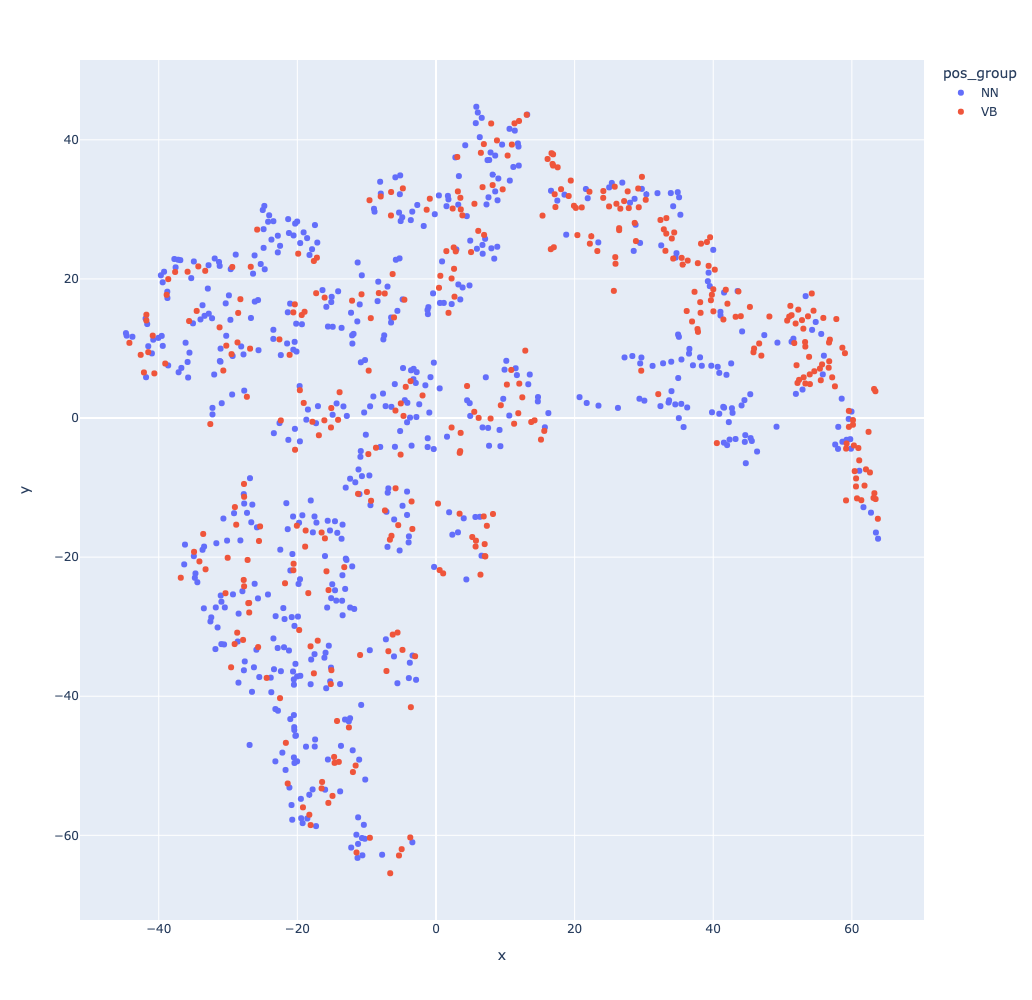

In [235]:
px.scatter(coords.reset_index(), 'x', 'y',  
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [236]:
def complete_analogy_aus(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None

def complete_analogy_mel(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_mel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [237]:
complete_analogy_aus('snape','professor','harry', 5)

term       sim
0    she  0.986099
1     he  0.981088
2   they  0.977686
3  there  0.961180
4   then  0.933550

In [238]:
get_most_similar('castle')

term       sim
0     until  0.998762
1    moving  0.998716
2  slightly  0.998706
3       bag  0.998658
4       red  0.998647
5       yet  0.998550
6       job  0.998544
7   feeling  0.998377
8     other  0.998275
9     while  0.998249

In [239]:
coords

vector          x  \
term_str                                                                  
harry      [-0.17052941, -0.057045467, 0.0059773717, 0.10...  44.698845   
said       [-0.17760296, -0.042440016, 0.002232576, 0.194...  40.520767   
was        [-0.094251074, -0.020802602, -0.0705955, -0.11...  63.250351   
s          [-0.045015827, -0.061373558, 0.00056705595, 0....  -3.709254   
had        [-0.09301863, -0.045515385, -0.05107396, 0.002...  62.408249   
...                                                      ...        ...   
soared     [-0.08236756, -0.05662087, -0.017745195, 0.146... -17.286777   
nodding    [-0.08183735, -0.054360047, -0.0150756035, 0.1... -41.785606   
detention  [-0.079326965, -0.056723703, -0.013306178, 0.1... -31.205648   
gaunt      [-0.08639518, -0.05923915, -0.012019449, 0.160... -25.670361   
lived      [-0.07920556, -0.056525417, -0.012121003, 0.14... -33.292820   

                   y      n         p          i  n_chars max_pos  n_pos  \
term_str                                                                   
harry      -6.496927  18258  0.016327   5.936604        5     NNP      5   
said       -3.606238  14491  0.012958   6.269975        4     VBD      2   
was       -10.813725  15647  0.013992   6.159246        3     VBD      4   
s         -60.306534  14796  0.013231   6.239925        1     VBD     19   
had        -1.989656  10165  0.009090   6.781522        3     VBD      3   
...              ...    ...       ...        ...      ...     ...    ...   
soared     17.946077     82  0.000073  13.735293        6     VBD      2   
nodding    14.025861     65  0.000058  14.070477        7     VBG      2   
detention  21.870117     89  0.000080  13.617111        9      NN      3   
gaunt      16.957253     72  0.000064  13.922920        5     NNP      3   
lived      21.161137     88  0.000079  13.633413        5     VBD      3   

                                                     cat_pos  stop  \
term_str                                                             
harry                                 {RP, VBP, NNP, NN, VB}     0   
said                                              {NNP, VBD}     0   
was                                       {VB, NNP, VBD, IN}     1   
s          {VBN, CC, VBD, VB, FW, JJR, VBP, POS, RBS, PRP...     1   
had                                          {VBN, NNP, VBD}     1   
...                                                      ...   ...   
soared                                            {VBN, VBD}     0   
nodding                                            {VBG, NN}     0   
detention                                     {NN, NNP, VBP}     0   
gaunt                                          {NN, NNP, JJ}     0   
lived                                        {VBN, NNP, VBD}     0   

          stem_porter stem_snowball stem_lancaster      dfidf  mean_tfidf  \
term_str                                                                    
harry           harri         harri          harry   0.000000    0.000000   
said             said          said           said   0.433201    0.000625   
was                wa           was            was   0.000000    0.000000   
s                   s             s              s   0.000000    0.000000   
had               had           had            had   0.000000    0.000000   
...               ...           ...            ...        ...         ...   
soared           soar          soar           soar  30.716971    0.000821   
nodding           nod           nod            nod  30.588803    0.000755   
detention      detent        detent            det  29.260381    0.001058   
gaunt           gaunt         gaunt          gaunt  20.509309    0.001333   
lived            live          live            liv  30.949759    0.000967   

          pos_group  
term_str             
harry            NN  
said             VB  
was              VB  
s                VB  
had              VB  
...             ...  


In [240]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, term_pos_pat = r'^(N|V)', color_thresh=1):
    term_filter = coords.max_pos.str.match(term_pos_pat) & (coords.stop == 0) & (coords.index.str.len() > 2)
    M = coords[term_filter].sort_values('mean_tfidf', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

<Figure size 432x288 with 0 Axes>

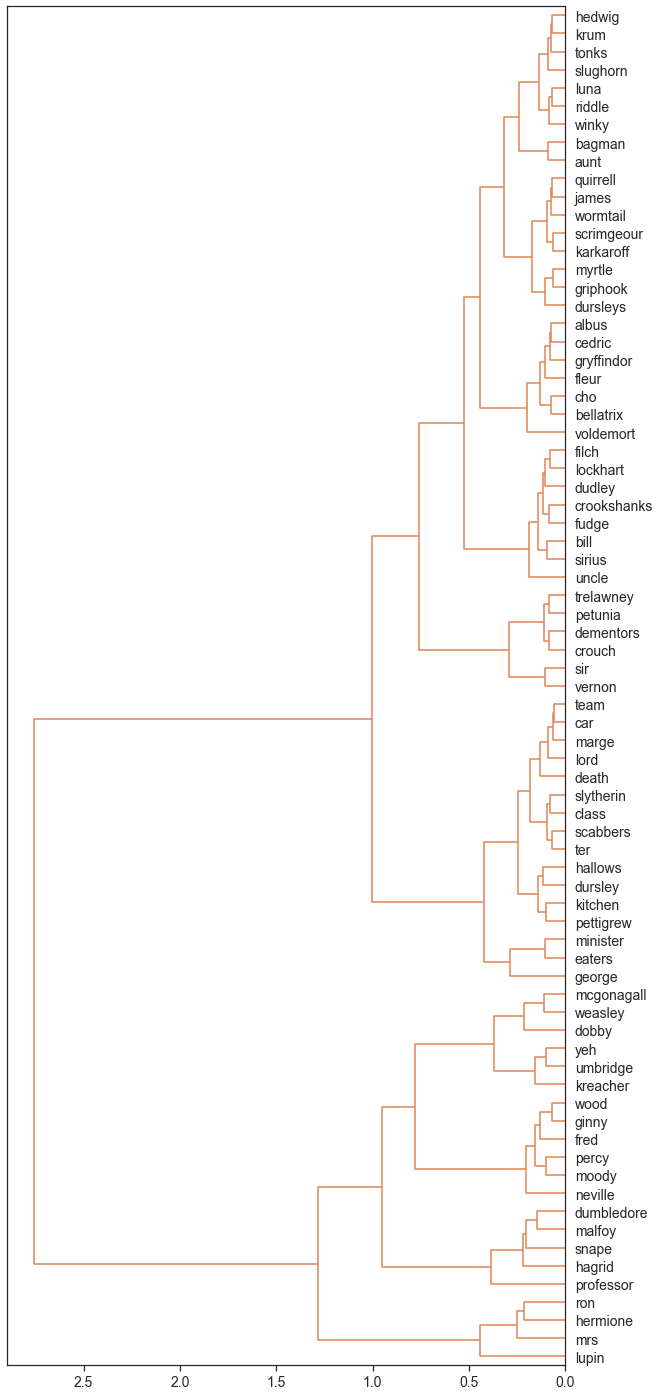

In [241]:
plot_terms_tree(coords, term_pos_pat=r'^NN[^P]?', color_thresh=9, terms_n=75)

## Get SA Lexicon

In [248]:
SALEX = pd.read_csv('salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative

In [249]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1) 

In [250]:
V.head()

n         p          i  n_chars max_pos  n_pos  \
term_str                                                        
harry      18258  0.016327   5.936604        5     NNP      5   
professor   2029  0.001814   9.106292        9     NNP      4   
don         1963  0.001755   9.154000        3     VBP      8   
good        1002  0.000896  10.124178        4      JJ      5   
black        932  0.000833  10.228659        5      JJ      4   

                                         cat_pos  stop stem_porter  \
term_str                                                             
harry                     {RP, VBP, NNP, NN, VB}     0       harri   
professor                     {NN, VB, NNP, VBP}     0   professor   
don        {VBP, VBZ, VB, NNP, NNS, VBD, NN, JJ}     1         don   
good                      {VB, NNP, VBD, NN, JJ}     0        good   
black                          {NN, VB, NNP, JJ}     0       black   

          stem_snowball  ... disgust  fear  joy negative  positive  sadness  \
term_str                 ...                                                  
harry             harri  ...       0     0    0        1         0        1   
professor     professor  ...       0     0    0        0         1        0   
don                 don  ...       0     0    0        0         1        0   
good               good  ...       0     0    1        0         1        0   
black             black  ...       0     0    0        1         0        1   

           surprise  trust  sentiment  polarity  
term_str                                         
harry             0      0         -1        -1  
professor         0      1          1         1  
don               0      1          1         1  
good              1      1          1         1  
black             0      0         -1        -1  

[5 rows x 26 columns]

In [251]:
DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
TF = (DTCM.T / DTCM.T.max()).T

BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

In [252]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [253]:
B

n        tf     tfidf max_pos  anger  anticipation  \
book_id chap_num term_str                                                       
1       1.0      amuse     1  0.004926  0.008974      VB    0.0           0.0   
                 angry     1  0.004926  0.001249      JJ    1.0           0.0   
                 anxious   1  0.004926  0.002638      JJ    0.0           1.0   
                 approve   1  0.004926  0.006624      NN    0.0           0.0   
                 aunt      2  0.009852  0.005581     NNP    0.0           0.0   
...                       ..       ...       ...     ...    ...           ...   
7       37.0     vanished  1  0.013699  0.003473     VBD    0.0           0.0   
                 watch     2  0.027397  0.005250      NN    0.0           1.0   
                 white     1  0.013699  0.002579      JJ    0.0           1.0   
                 worried   1  0.013699  0.004854      JJ    0.0           0.0   
                 worry     2  0.027397  0.009709      NN    0.0           1.0   

                           disgust  fear  joy  sadness  surprise  trust  \
book_id chap_num term_str                                                 
1       1.0      amuse         0.0   0.0  1.0      0.0       0.0    0.0   
                 angry         1.0   0.0  0.0      0.0       0.0    0.0   
                 anxious       0.0   1.0  0.0      0.0       0.0    0.0   
                 approve       0.0   0.0  1.0      0.0       0.0    1.0   
                 aunt          0.0   0.0  0.0      0.0       0.0    1.0   
...                            ...   ...  ...      ...       ...    ...   
7       37.0     vanished      0.0   1.0  0.0      1.0       1.0    0.0   
                 watch         0.0   1.0  0.0      0.0       0.0    0.0   
                 white         0.0   0.0  1.0      0.0       0.0    1.0   
                 worried       0.0   0.0  0.0      1.0       0.0    0.0   
                 worry         0.0   1.0  0.0      1.0       0.0    0.0   

                           polarity  
book_id chap_num term_str            
1       1.0      amuse          1.0  
                 angry         -1.0  
                 anxious       -1.0  
                 approve        1.0  
                 aunt           1.0  
...                             ...  
7       37.0     vanished      -1.0  
                 watch          0.0  
                 white          1.0  
                 worried       -1.0  
                 worry         -1.0  

[33197 rows x 13 columns]

In [254]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [255]:
## Emotion word counts by POS 

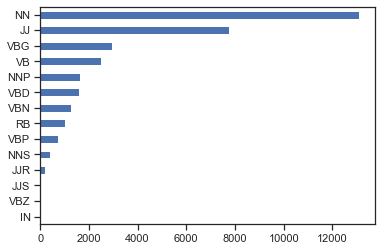

In [256]:
B.max_pos.value_counts().sort_values().plot.barh();

In [257]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()

In [258]:
EMO_BOOKS.index = LIB.title #book_title

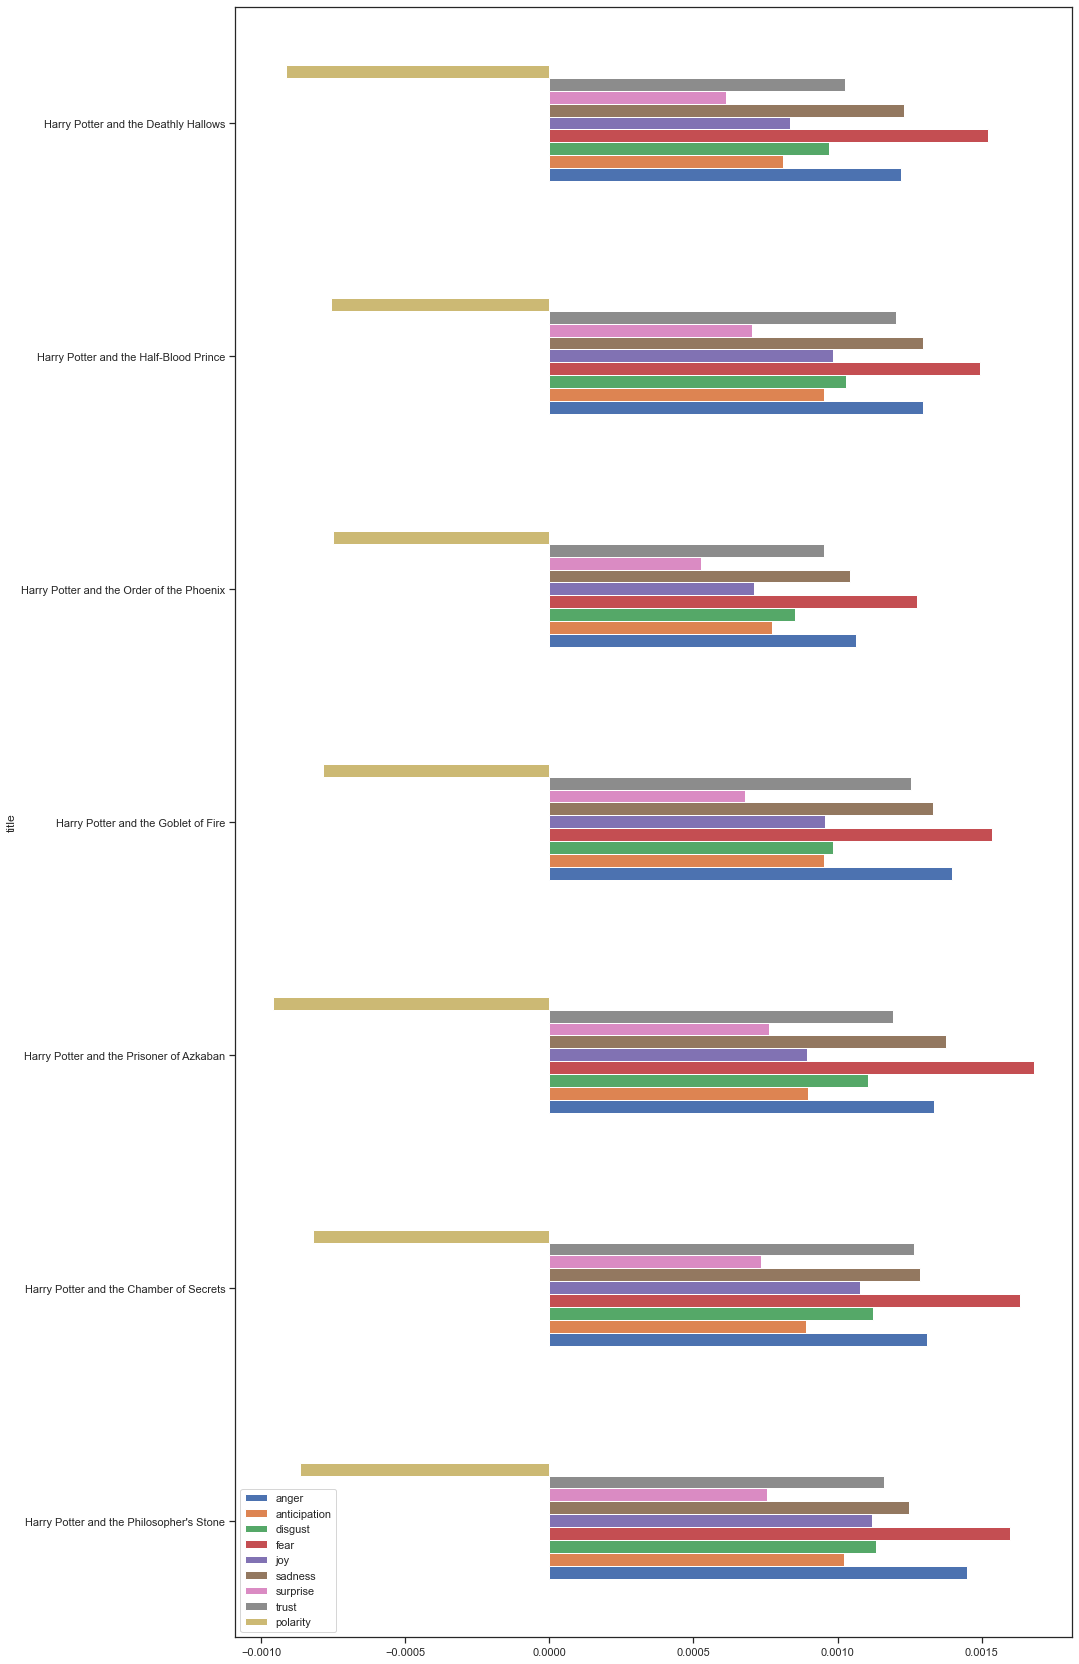

In [259]:
EMO_BOOKS.plot.barh(figsize=(15,30));

## Going more in depth with book 7

In [260]:
EMO_CHAPS

anger  anticipation   disgust      fear       joy  \
book_id chap_num                                                         
1       1.0       0.001028      0.001422  0.000936  0.001474  0.001735   
        2.0       0.001218      0.001367  0.001626  0.001777  0.001592   
        3.0       0.001279      0.000699  0.001207  0.001059  0.000477   
        4.0       0.002318      0.001325  0.001850  0.002692  0.001282   
        5.0       0.001017      0.001028  0.001204  0.001226  0.000967   
...                    ...           ...       ...       ...       ...   
7       33.0      0.000924      0.000626  0.000811  0.001042  0.000610   
        34.0      0.001001      0.000936  0.001119  0.001963  0.001026   
        35.0      0.001827      0.001206  0.001671  0.002305  0.001208   
        36.0      0.001093      0.000710  0.000555  0.001348  0.000738   
        37.0      0.002901      0.003572  0.001131  0.002352  0.003897   

                   sadness  surprise     trust  polarity  
book_id chap_num                                          
1       1.0       0.000938  0.000993  0.001475  0.000328  
        2.0       0.001257  0.001145  0.001910 -0.000257  
        3.0       0.000925  0.000255  0.001287 -0.001230  
        4.0       0.002371  0.001123  0.001158 -0.002923  
        5.0       0.000906  0.000727  0.001193 -0.000577  
...                    ...       ...       ...       ...  
7       33.0      0.001014  0.000530  0.000918 -0.000701  
        34.0      0.001652  0.000586  0.001312 -0.001128  
        35.0      0.001795  0.000731  0.001784 -0.000955  
        36.0      0.001086  0.000578  0.000926 -0.000637  
        37.0      0.002986  0.001638  0.003711 -0.000339  

[199 rows x 9 columns]

In [261]:
book7_chaps = EMO_CHAPS.loc[7] 

## Mean sentiment by chapter 

In [262]:
book7_chaps.style.background_gradient(cmap='YlGnBu', axis=None)

In [263]:
book7_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(7))

In [264]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

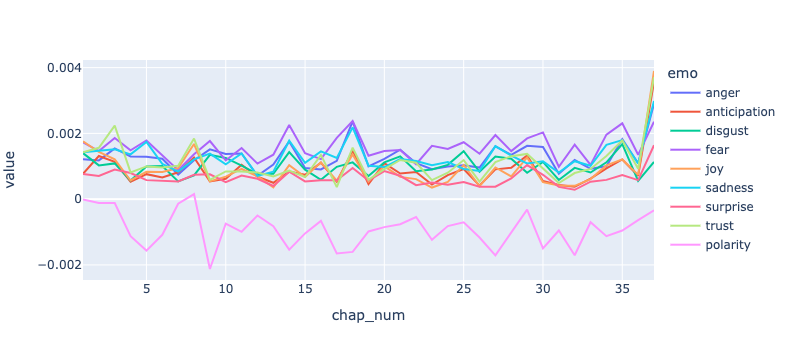

In [265]:
px.line(book7_chaps_thin, x='chap_num', y='value', color='emo')

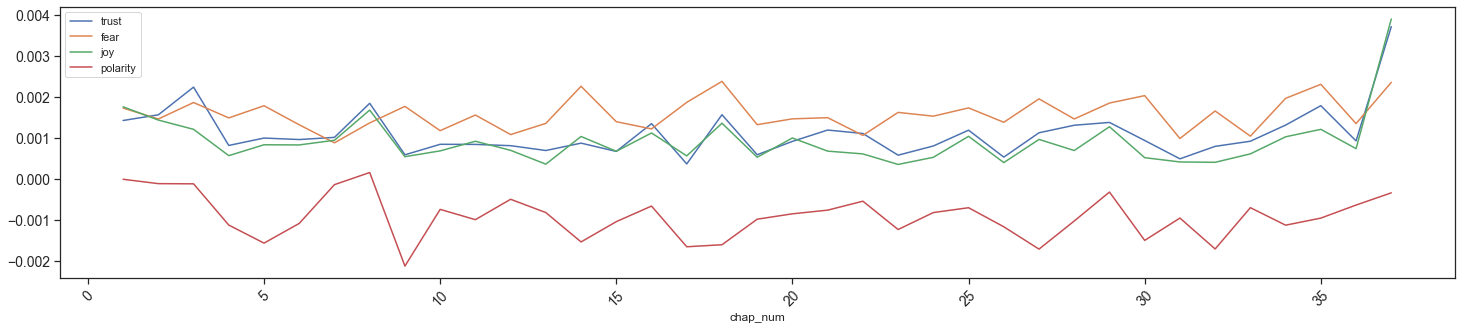

In [266]:
plot_sentiments(book7_chaps, ['trust','fear','joy','polarity'])

## Cose Read Sentiment in Texts

In [267]:
T = CORPUS.join(V, on='term_str').fillna(0)

In [268]:
T

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr   
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   5                (of, IN)   IN        of   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str    n    p    i  \
book_id chap_num para_num sent_num token_num                            
1       1.0      0        0        0                mr  0.0  0.0  0.0   
                                   1               and  0.0  0.0  0.0   
                                   2               mrs  0.0  0.0  0.0   
                                   3           dursley  0.0  0.0  0.0   
                                   5                of  0.0  0.0  0.0   
...                                                ...  ...  ...  ...   
7       37.0     78       0        7          nineteen  0.0  0.0  0.0   
                                   8             years  0.0  0.0  0.0   
                          1        0               all  0.0  0.0  0.0   
                                   1               was  0.0  0.0  0.0   
                                   2              well  0.0  0.0  0.0   

                                              n_chars max_pos  n_pos  ...  \
book_id chap_num para_num sent_num token_num                          ...   
1       1.0      0        0        0              0.0       0    0.0  ...   
                                   1              0.0       0    0.0  ...   
                                   2              0.0       0    0.0  ...   
                                   3              0.0       0    0.0  ...   
                                   5              0.0       0    0.0  ...   
...                                               ...     ...    ...  ...   
7       37.0     78       0        7              0.0       0    0.0  ...   
                                   8              0.0       0    0.0  ...   
                          1        0              0.0       0    0.0  ...   
                                   1              0.0       0    0.0  ...   
                                   2              0.0       0    0.0  ...   

                                             disgust  fear  joy negative  \
book_id chap_num para_num sent_num token_num                               
1       1.0      0        0        0             0.0   0.0  0.0      0.0   
                                   1             0.0   0.0  0.0      0.0   
                                   2             0.0   0.0  0.0      0.0   
                                   3             0.0   0.0  0.0      0.0   
                                   5             0.0   0.0  0.0      0.0   
...                                              ...   ...  ...      ...   
7       37.0     78       0        7             0.0   0.0  0.0      0.0   
                                   8             0.0   0.0  0.0      0.0   
                          1        0             0.0   0.0  0.0      0.0   
                                   1             0.0   0.0  0.0      0.0   
                                   2             0.0   0.0  0.0      0.0   

                                             positive  sadness  surprise  \
book_i

In [269]:
book7 = T.loc[7].copy()

In [270]:
emo = 'polarity'
book7['html'] = book7.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)

In [271]:
SENTS = OHCO[:4]
book7_sents = book7.groupby(SENTS[1:])[emo_cols].mean()

In [272]:
book7_sents['sent_str'] = book7.groupby(SENTS[1:]).term_str.apply(lambda x: x.str.cat(sep=' '))

In [273]:
book7_sents['html_str'] = book7.groupby(SENTS[1:]).html.apply(lambda x: x.str.cat(sep=' '))

In [274]:
from IPython.display import display, HTML

def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [275]:
sample_sentences(book7_sents)

## Trying VADER

In [280]:
# pip install vaderSentiment

In [281]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [282]:
book7_vader_cols = book7_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
book7_vader = pd.concat([book7_sents, book7_vader_cols], axis=1)

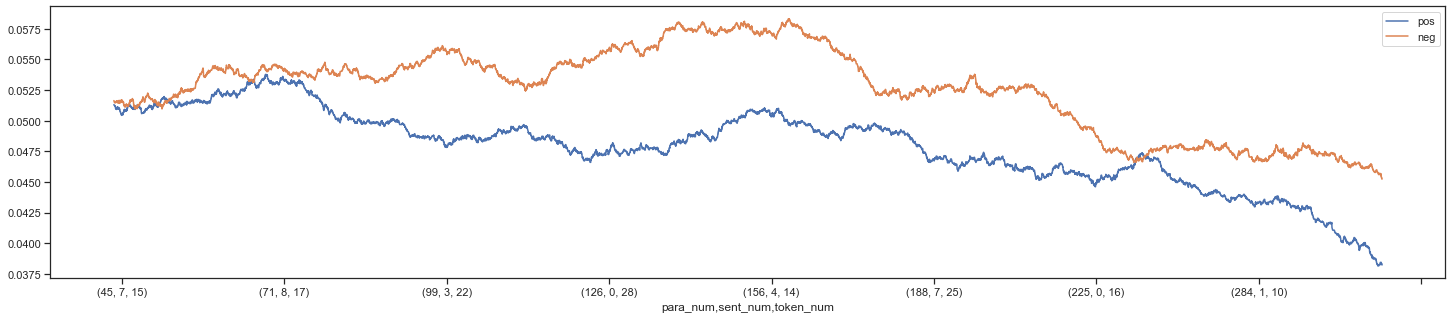

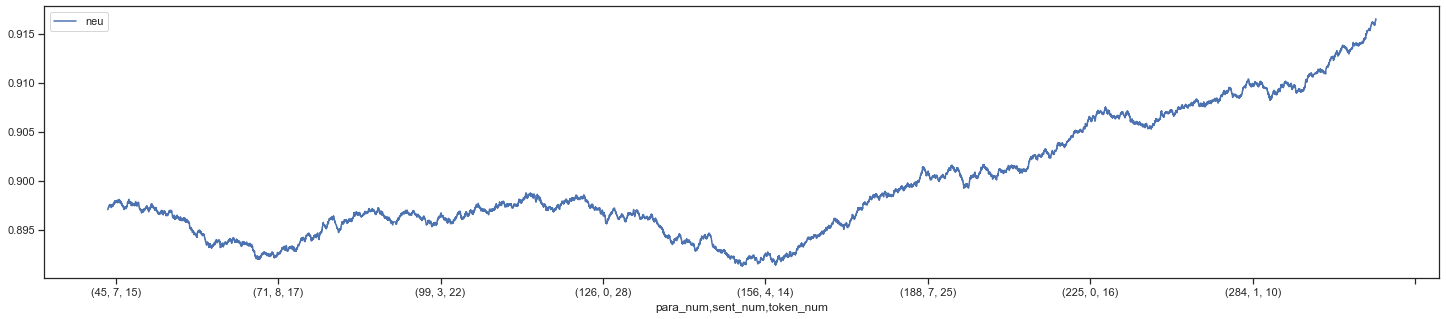

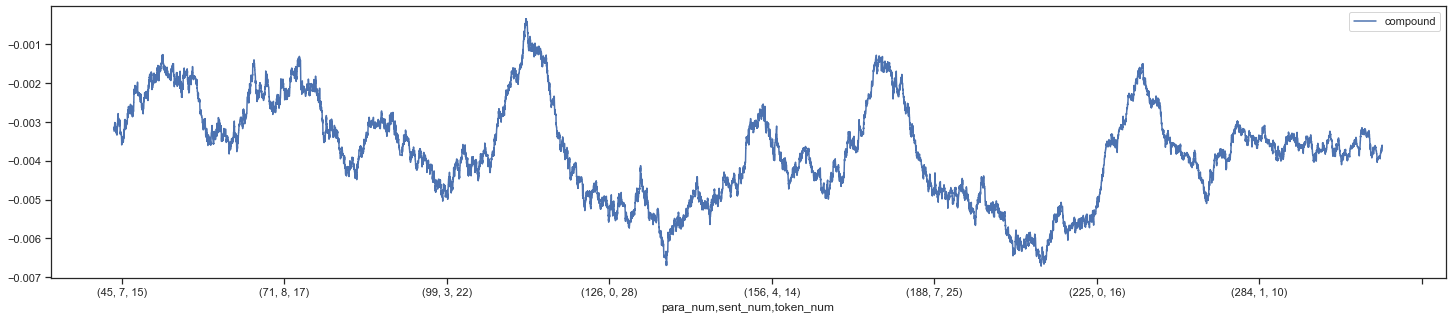

In [283]:
w = int(book7_vader.shape[0] / 5)
book7_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
book7_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
book7_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

## Emo Space

In [295]:
import sys; sys.path.append("../lib/")

In [285]:
EMOX = B[emo_cols].groupby('book_id').mean()\
    .join(LIB.title).reset_index(drop=True).set_index('title')

In [286]:
EMOX.sort_values('polarity').style.background_gradient(cmap='Spectral', axis=None)

In [298]:
class HAC:
    """
    Takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. 
    The number of observations should be sufficiently 
    small to allow being plotted.
    Attributes:
        w (int): The
        width of the figure in inches.
        label_size (int): The font size of the labels in points.
        orientation (str): The orientation of the figure; 'top', 'bottom', 'left', 'right'. Defaults to 'left'.
        dist_measure (str): The distance measure to use; braycurtis, canberra, chebyshev, cityblock, correlation, 
            cosine, dice, euclidean, hamming, jaccard, jensenshannon, kulsinski, kulczynski1, mahalanobis, matching, 
            minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule. 
            Defaults to euclidean.
        linkage_method (str): The linkage method to use; single, complete, average, weighted, centroid, median, ward
            Defaults to ward.
        norm_type (str): The vector normalization type; l1, l2, max. Defaults to l2.
        color_thresh (float): The threshhold at which to apply coloring in the dendropgram. Defaults to None.
    """

    w:int = 10
    label_size:int = 14
    orientation:str = 'left'
    dist_metric:str = 'cosine' 
    linkage_method:str = 'ward' 
    norm_type:str = 'l2' 
    color_thresh:float = None
    
    def __init__(self, X, labels=None):
        self.X = X
        self.h = X.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = X.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.X, norm=self.norm_type), metric=self.dist_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.linkage_method)        
        
    def plot_tree(self):
        if not self.color_thresh:
            self.color_thresh = df(self.TREE)[2].median()
        plt.figure()
        plt.subplots(figsize=(self.w, self.h / 3))
        sch.dendrogram(self.TREE, 
            labels=self.labels, 
            orientation=self.orientation,
            count_sort=True,
            distance_sort=True,
            above_threshold_color='.75',
            color_threshold=self.color_thresh);
        plt.tick_params(axis='both', which='major', labelsize=self.label_size)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

<Figure size 432x288 with 0 Axes>

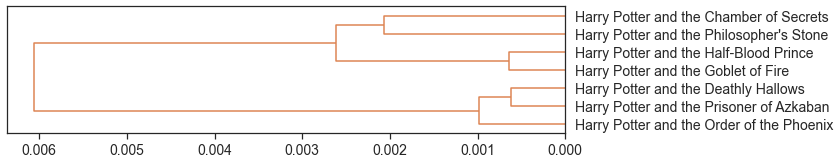

In [299]:
emo_tree = HAC(EMOX)
emo_tree.color_thresh=.03
emo_tree.plot()

# Visualizations

## Word Dispersion Plots

In [300]:
D = pd.get_dummies(CORPUS.term_str)

def word_plot(term_str):
    D[term_str].plot(figsize=(10, .5), legend=False, title=term_str.upper());

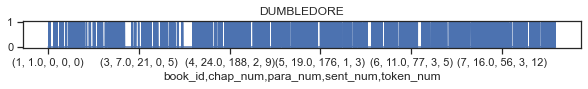

In [301]:
word_plot('dumbledore') # from M01_04_Further_Exploration

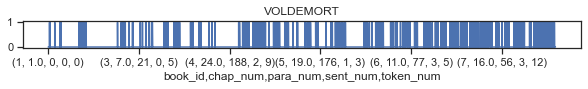

In [302]:
word_plot('voldemort')

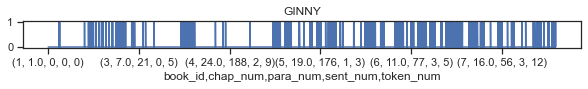

In [303]:
word_plot('ginny')

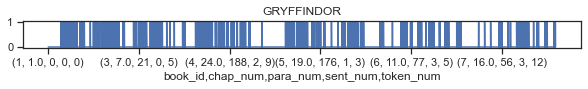

In [304]:
word_plot('gryffindor')

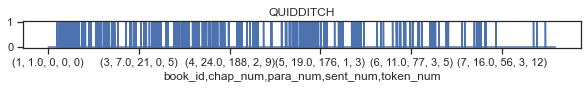

In [305]:
word_plot('quidditch')

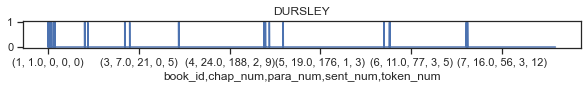

In [306]:
word_plot('dursley')

## Correlation Plots

In [307]:
CORR = CORPUS[['term_str']].reset_index()
CORR.set_index('token_num')[['term_str']]

term_str
token_num          
0                mr
1               and
2               mrs
3           dursley
5                of
...             ...
7          nineteen
8             years
0               all
1               was
2              well

[1118276 rows x 1 columns]

In [308]:
CORR['centile'] = (CORR.index * 100 / len(CORR)).astype('int') + 1

In [309]:
M = [None, None]
M[0] = CORR.groupby(['centile','term_str']).term_str.count().unstack(fill_value=0)
M[1] = M[0] / M[0].sum()

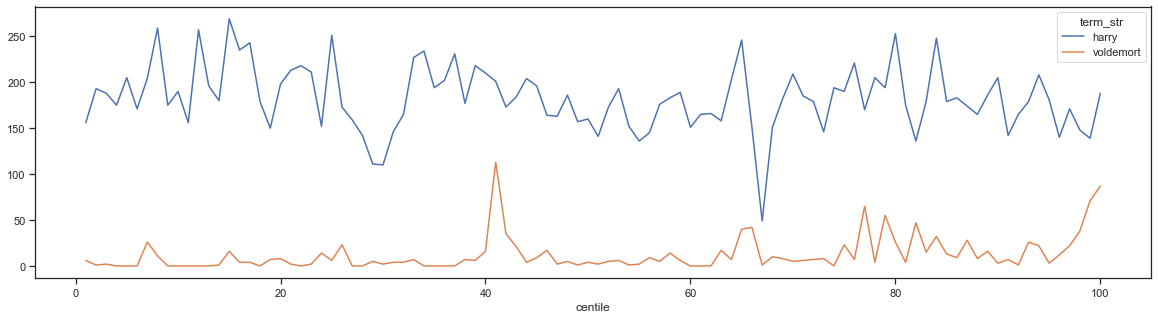

In [310]:
M[0][['harry','voldemort']].plot(figsize=(20,5), style='-');

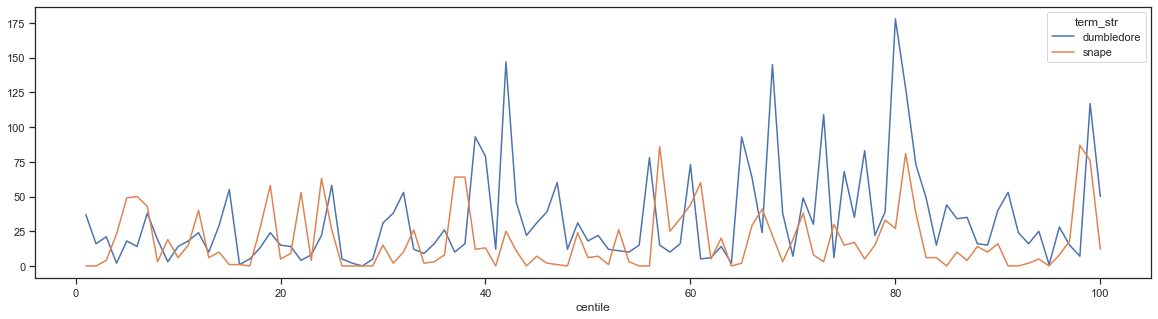

In [311]:
M[0][['dumbledore','snape']].plot(figsize=(20,5), style='-');

## POS Illustration

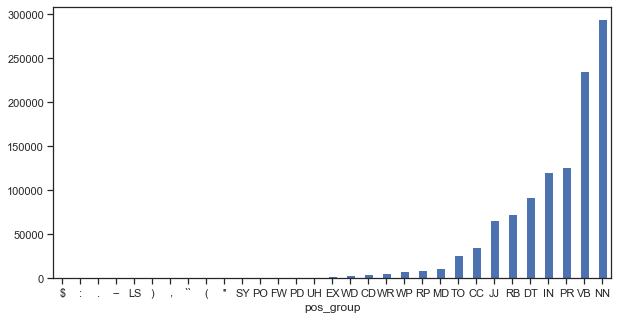

In [312]:
POS.groupby('pos_group').n.sum().sort_values().plot.bar(figsize=(10,5), rot=0);

In [313]:
def plot_pos():
    X = POS_GROUP[['n_terms','n_tokens', 'pos_def']].dropna().sort_values('n_terms')
    labels = X['pos_def']
    Y = X[['n_terms', 'n_tokens']]
    Z = ((Y - Y.mean(numeric_only=True)) / Y.std(numeric_only=True))
    return px.bar(Z, height=600, hover_name=labels, title="Comparison of Z-scores for POS token and term counts")

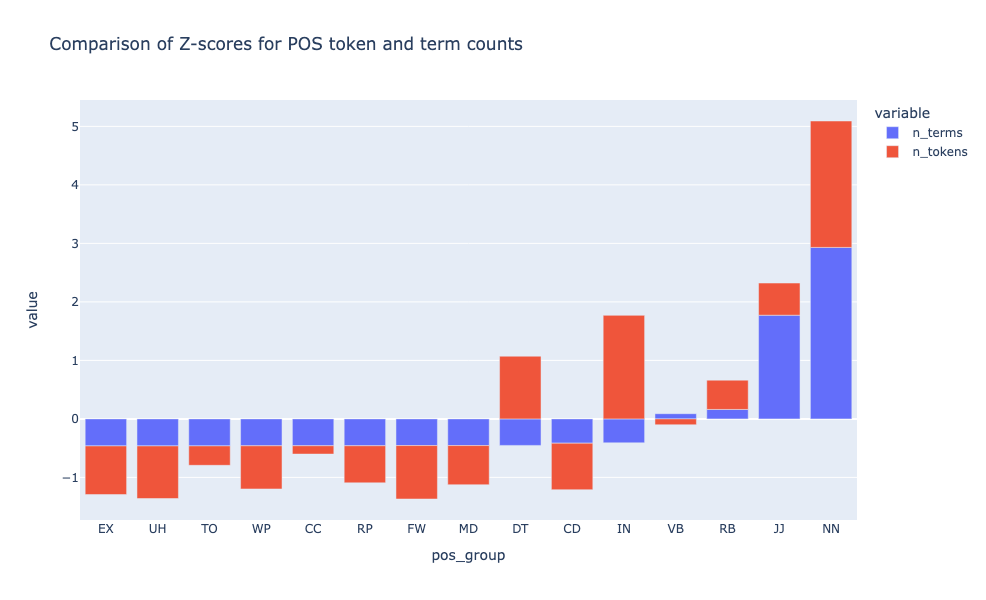

In [314]:
plot_pos()

## Correlation Dendograms

<Figure size 432x288 with 0 Axes>

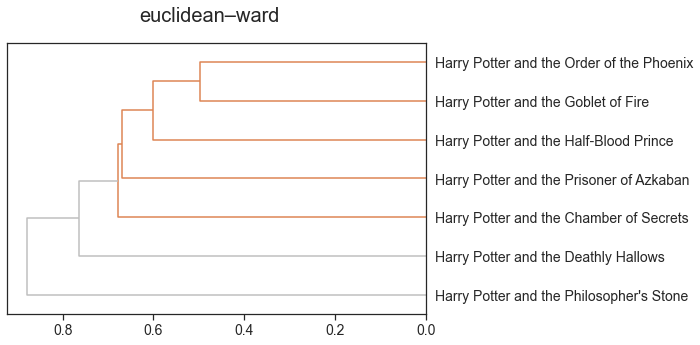

<Figure size 432x288 with 0 Axes>

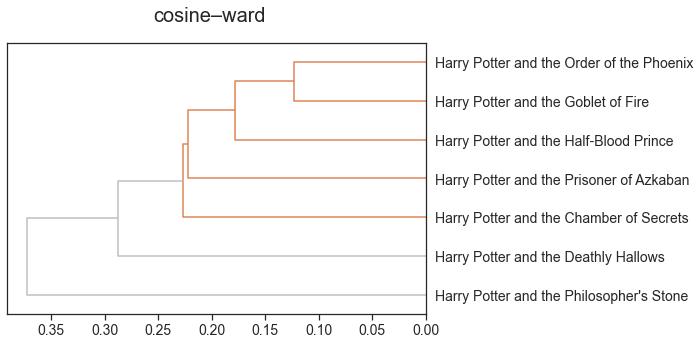

<Figure size 432x288 with 0 Axes>

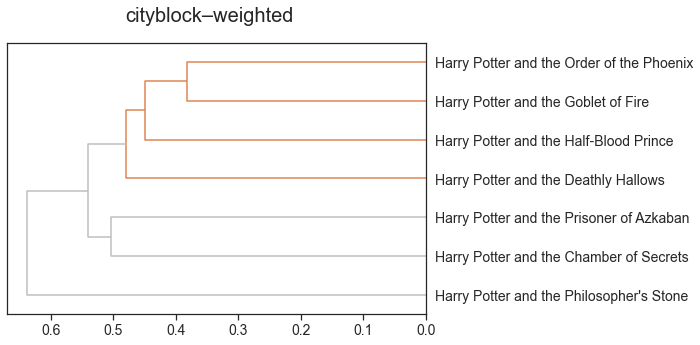

<Figure size 432x288 with 0 Axes>

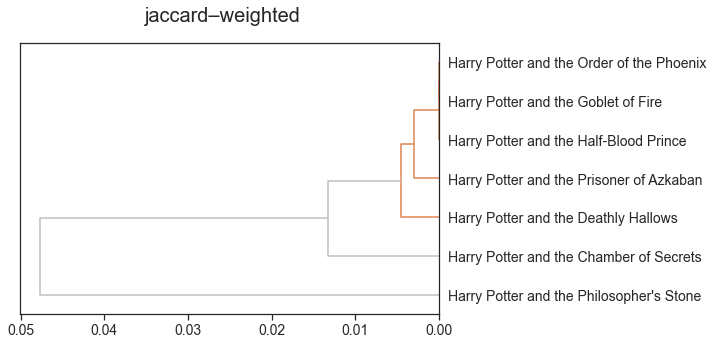

<Figure size 432x288 with 0 Axes>

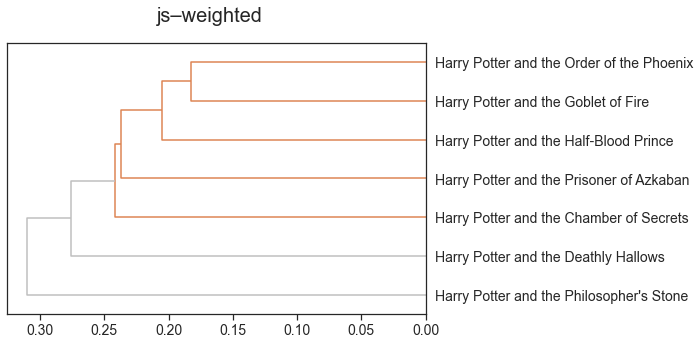

In [315]:
# Define function
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.title.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{title}–{linkage_method}", fontsize=20)

for X, metric, title, linkage in combos:
    draw_hca(PAIRS[title], linkage_method=linkage)

## Compare Correlations with Kendall Sum

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


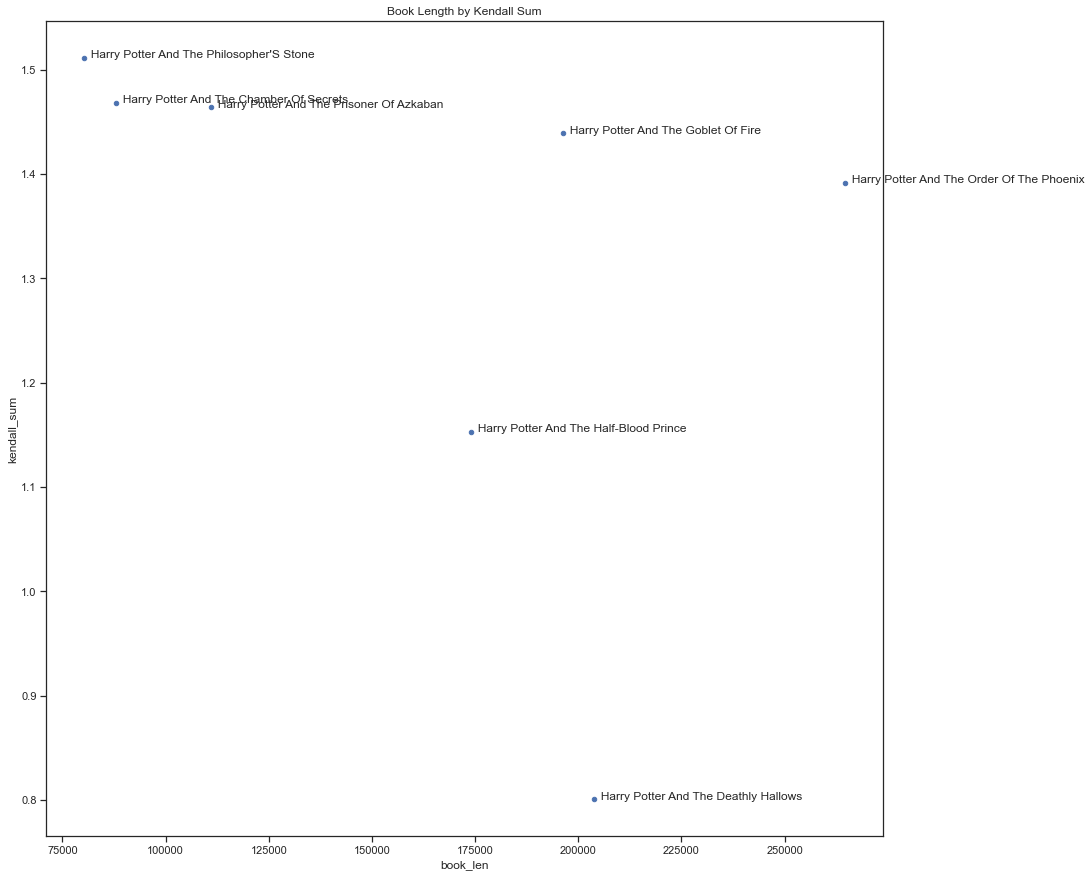

In [316]:
ax = LIB.plot.scatter('book_len', 'kendall_sum', figsize=(15,15), title="Book Length by Kendall Sum")
LIB.apply(lambda row: ax.text(row.book_len, row.kendall_sum, f"  {row.title.title()}"), axis=1);

## Strip Plots to Compare Multiple Word Frequencies

In [317]:
B1 = BOOK1['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B2 = BOOK2['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B3 = BOOK3['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B4 = BOOK4['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B5 = BOOK5['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B6 = BOOK6['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B7 = BOOK7['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})

In [318]:
def plot_words(words, book, num):    
    
    X = book[book.term_str.isin(words)]
    
    plt.figure(figsize=(22, len(words)))
    
    ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
    ax.set_title('Dispersion Plots Book ' + str(num), size=30, pad=20)
    ax.set_xlabel('Narrative Time', size=20)
    ax.set_ylabel('Term', size=20)
    
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.tight_layout()
    plt.show()

In [319]:
names = 'ron hermione'.split()

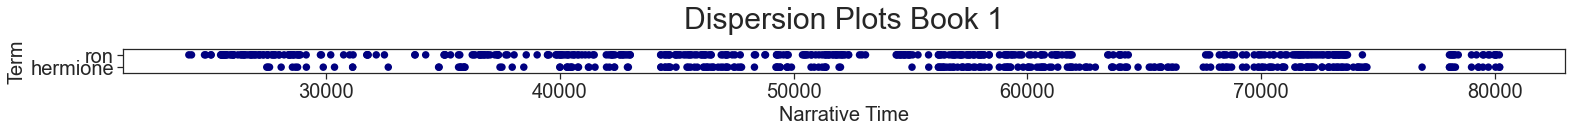

In [320]:
plot_words(names, B1, 1)

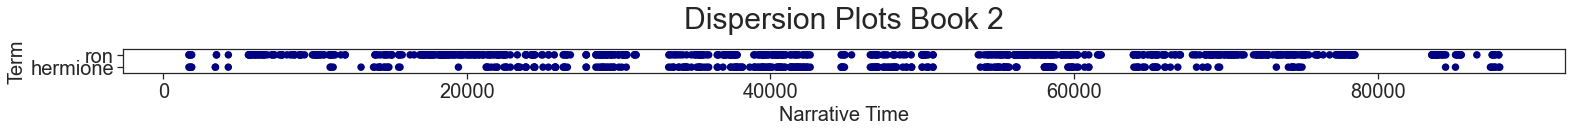

In [321]:
plot_words(names, B2, 2)

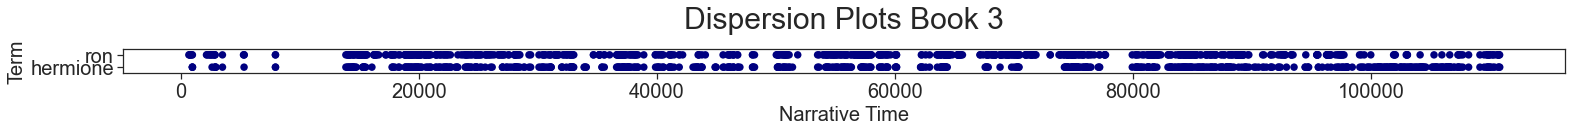

In [322]:
plot_words(names, B3, 3)

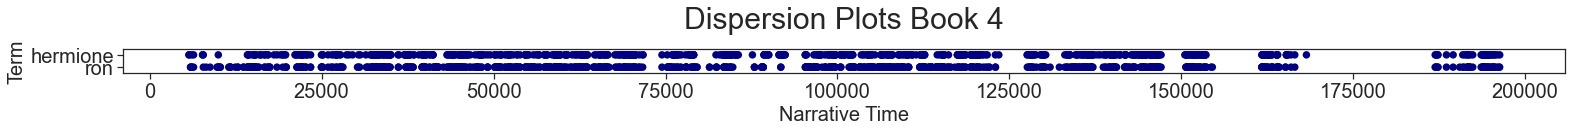

In [323]:
plot_words(names, B4, 4)

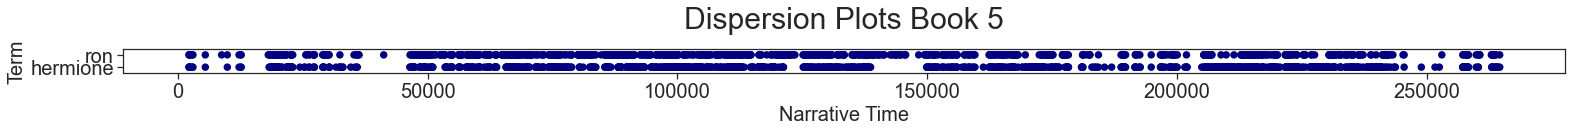

In [324]:
plot_words(names, B5, 5)

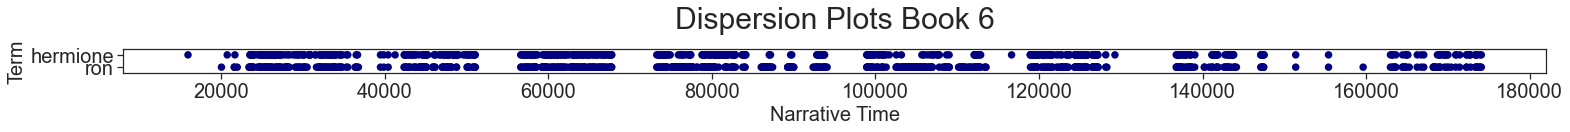

In [325]:
plot_words(names, B6, 6)

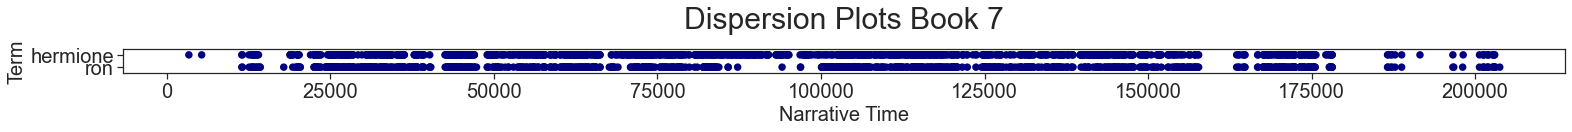

In [326]:
plot_words(names, B7, 7)

## Plot Chapter Significance

### Function to Plot Chapter Significance, `plot_sig_docs`

In [331]:
# Turn DOCS back into dataframe (from List)
DOCS = BOW.groupby(bag).n.sum().to_frame('n')
DOCS['book_chap_sig'] = TFIDF.T.mean().to_frame('book_chap_sig')

In [332]:
def plot_sig_docs(book_id, type='scatter'):

    global DOCS
    D = DOCS.loc[book_id]
    title = LIB.loc[book_id].title
    point_size = (D.n / D.n.sum()) * 700
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=D.index, y=D.book_chap_sig, 
                             text=D.index, 
                             mode = 'lines+markers+text',
                             marker = dict(size=point_size, color='#BBB'),
                             line = dict(color='#DADADA'),
                             textfont = dict(color="black")
                            ))
                  
    fig.update_layout(
        font = dict(color="#000", size=14),
        title=title,
        xaxis_title="Chapter",
        yaxis_title="Significance",
        height=800
    )
    fig.show()

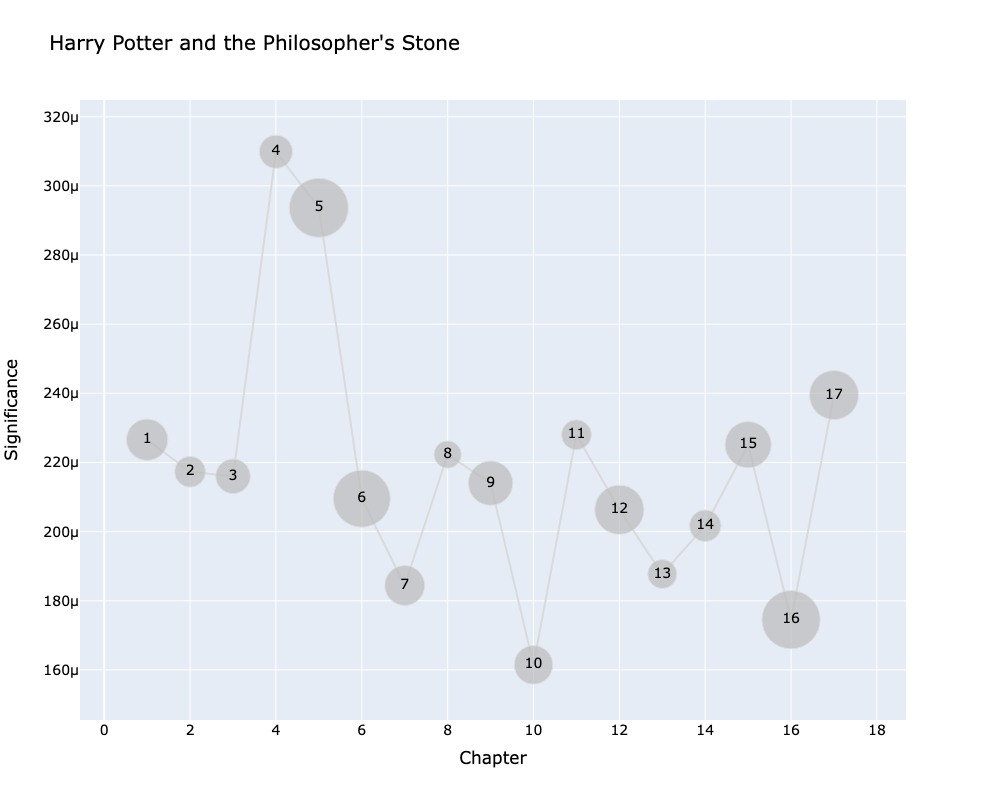

In [333]:
plot_sig_docs(1)

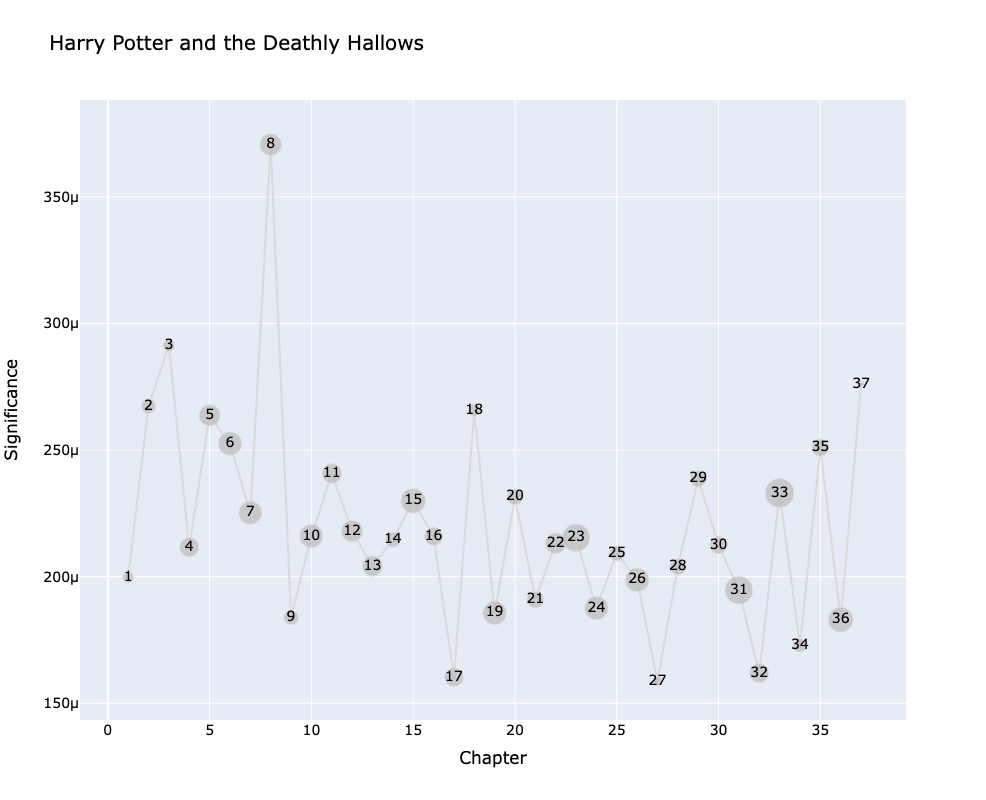

In [334]:
plot_sig_docs(7)

## PCA Visualizations

In [335]:
# note - if we want visualizations by book, we'd need to go back
# and do all the PCA preprocessing for each book, then visualize each book separately

# we could also go back and include proper nouns in our analysis and we could potentially see some contrasts with characters in PCA

# if we see individual words like 'w' or 't', these come from contractions and have meaning on their own - for example, 't' stands
# in for 'not'

In [336]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos',
                      marginal_x='box', height=800)

In [337]:
def vis_pcs(M, a, b, label='title', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

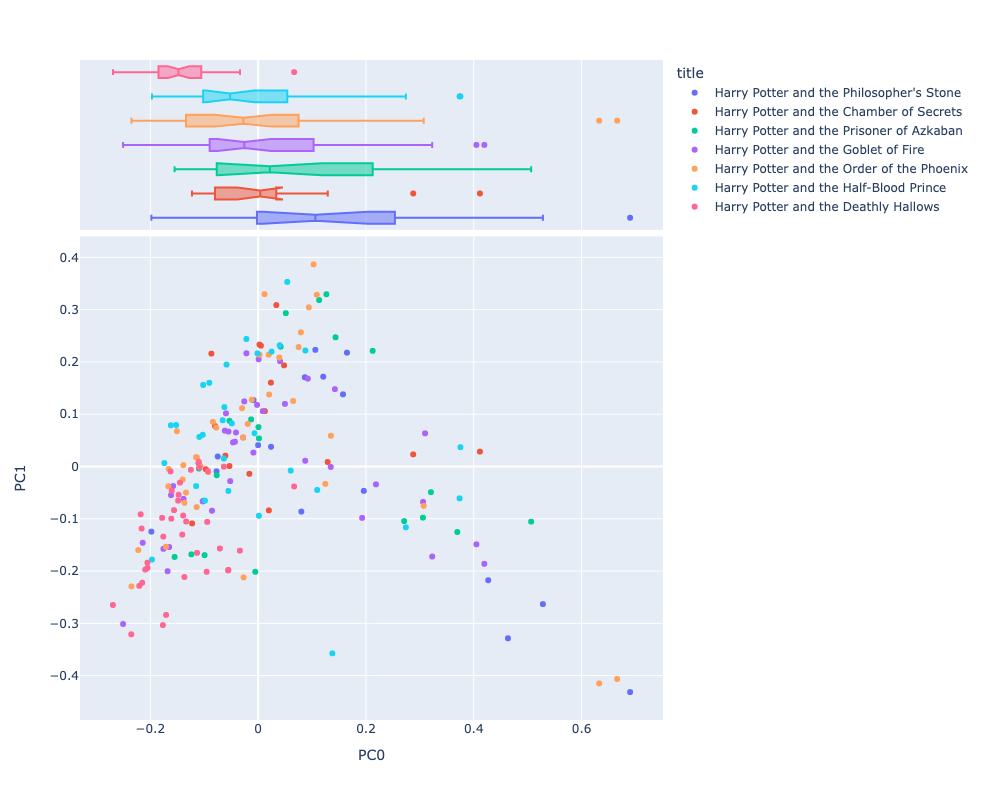

In [338]:
vis_pcs(DCM, 0, 1)

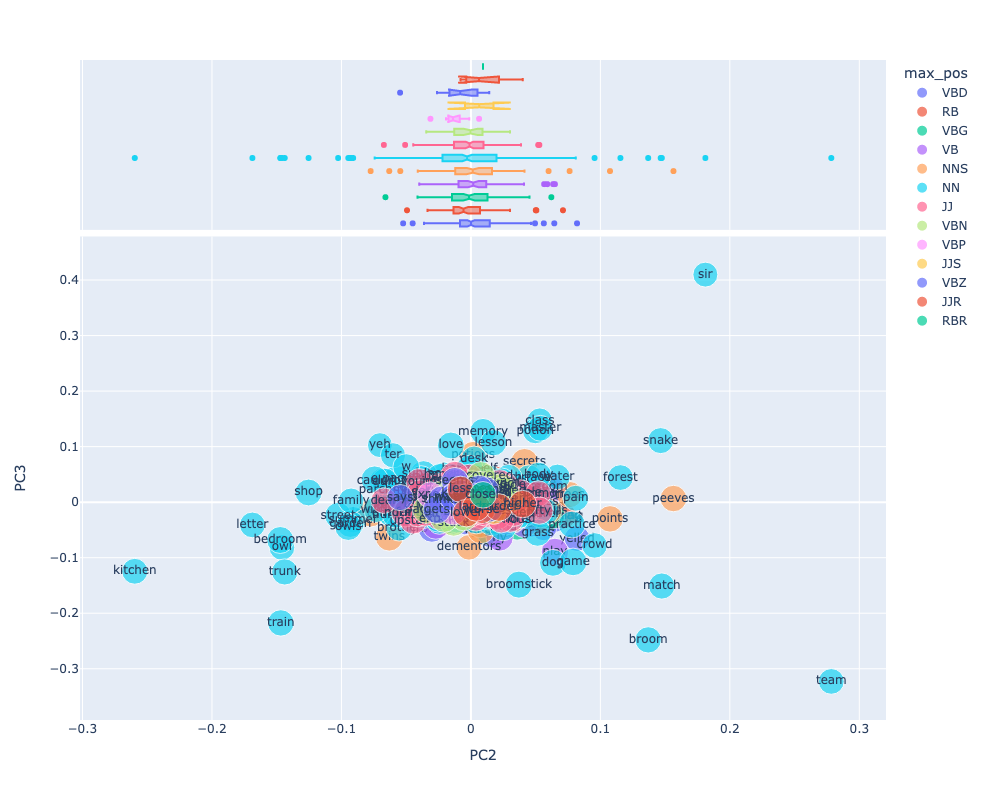

In [339]:
vis_loadings(2, 3)

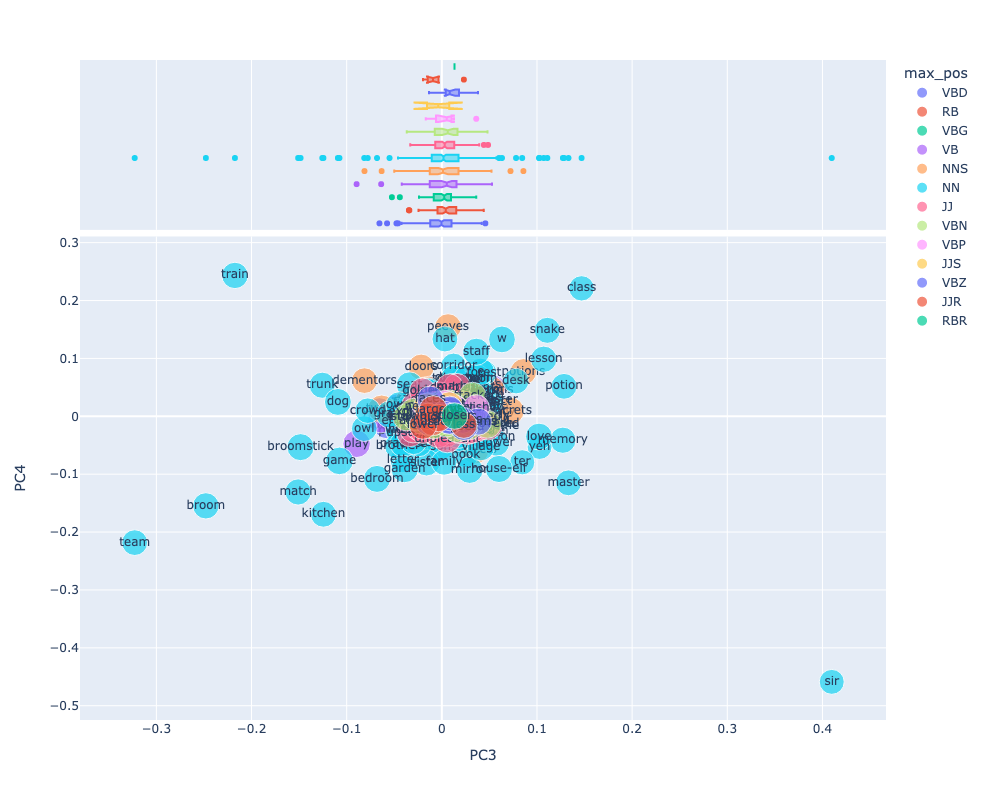

In [340]:
vis_loadings(3, 4) # the w as a word below comes from instances of a character saying "W - what?"

# Semantic Search

In [151]:
BAG = ['book_id', 'chap_num', 'para_num']

CORPUS_by_para = CORPUS.groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})\
    .reset_index()

CORPUS_text = CORPUS_by_para.para_str
CORPUS_text

0        mr and mrs dursley of number four privet drive...
1        mr dursley was the director of a firm called g...
2        the dursleys had everything they wanted but th...
3        met for several years in fact mrs dursley pret...
4        this boy was another good reason for keeping t...
                               ...                        
40736    the last trace of steam evaporated in the autu...
40737                    he ll be all right murmured ginny
40738    as harry looked at her he lowered his hand abs...
40739                                       i know he will
40740    the scar had not pained harry for nineteen yea...
Name: para_str, Length: 40741, dtype: object

In [ ]:
# Commented ode takes ~5 minutes to run, so we can just load the corpus embeddings instead

# corpus_embeddings = model.encode(CORPUS_text, convert_to_tensor=True, show_progress_bar=True, normalize_embeddings=True)
corpus_embeddings = torch.load("harrypotter.pt")

In [102]:
# torch.save(corpus_embeddings, "harrypotter.pt")

In [254]:
def search_potter(concept, top_k, books = [1, 2, 3, 4, 5, 6, 7]):
    # Get book indexes and filter corpus embeddings by book
    book_indexes = list(np.concatenate(([CORPUS_by_para[CORPUS_by_para['book_id'] == i].index for i in books])))
    global corpus_embeddings
    corpus_embeddings_subset = corpus_embeddings[book_indexes]
    
    #Encode the query
    query_embedding = model.encode(concept, convert_to_tensor=True)
    
    # Generate search hits
    potter_search_hits = util.semantic_search(query_embedding, corpus_embeddings_subset, top_k=top_k)[0]
    
    # Get row indexes of the top k hits
    potter_hit_indexes = [x['corpus_id'] for x in potter_search_hits]
    
    return pprint.pprint([{"Book Number: " + str(CORPUS_by_para.iloc[x]["book_id"]) + 
             ", Chapter Number: " + 
             str(int(CORPUS_by_para.iloc[x]["chap_num"]))
             :CORPUS_by_para.iloc[x]["para_str"]} for x in potter_hit_indexes])

search_potter("the scar had not pained harry for nineteen years all was well", 5, books=[1, 2])

[{'Book Number: 2, Chapter Number: 1': 'it was this scar that made harry so '
                                       'particularly unusual even for a wizard '
                                       'this scar was the only hint of harry s '
                                       'very mysterious past of the reason he '
                                       'had been left on the dursleys doorstep '
                                       'eleven years before'},
 {'Book Number: 1, Chapter Number: 16': 'well i was lucky once wasn t i said '
                                        'harry pointing at his scar i might '
                                        'get lucky again'},
 {'Book Number: 1, Chapter Number: 16': 'harry did the best he could trying to '
                                        'ignore the stabbing pains in his '
                                        'forehead which had been bothering him '
                                        'ever since his trip into the forest '
  

# TO DO

5. Conduct word2vec, maybe other methods

6. Visualize results

7. Present conclusions

In [ ]:
VOCAB

In [ ]:
CORPUS